#Modelo 1 tanque gravitacional

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Par√¢metros F√≠sicos do Tanque (Exemplo) ---
# Usaremos unidades do Sistema Internacional (metros, segundos, m¬≥)

G = 9.81  # Acelera√ß√£o da gravidade (m/s¬≤)

# Tanque cil√≠ndrico
DIAMETRO_TANQUE = 1.0  # Di√¢metro do tanque (m)
ALTURA_MAX_TANQUE = 2.0  # Altura m√°xima do tanque (m)
AREA_TANQUE = np.pi * (DIAMETRO_TANQUE / 2)**2 # √Årea da se√ß√£o transversal (m¬≤)

# Sa√≠da
DIAMETRO_SAIDA = 0.05  # Di√¢metro do orif√≠cio de sa√≠da (m)
AREA_SAIDA = np.pi * (DIAMETRO_SAIDA / 2)**2 # √Årea do orif√≠cio de sa√≠da (m¬≤)
CD = 0.85 # Coeficiente de descarga (adimensional)

# Entrada
Q_IN_MAX = 0.015 # Vaz√£o m√°xima de entrada (m¬≥/s), equivale a 10 litros/s

# Simula√ß√£o
DELTA_T = 0.2 # Passo de tempo da simula√ß√£o (s). 0.2 segundo.

# --- Fun√ß√£o do Modelo (Simulador) ---

def simular_passo_tanque(h_atual, acao_controlador):
    """
    Calcula o pr√≥ximo n√≠vel do tanque com base no n√≠vel atual e na a√ß√£o de controle.

    Args:
        h_atual (float): N√≠vel atual do l√≠quido em metros.
        acao_controlador (float): A√ß√£o de controle entre 0 e 1.

    Returns:
        float: O pr√≥ximo n√≠vel do l√≠quido em metros.
    """
    # Garante que a a√ß√£o do controlador esteja entre 0 e 1
    acao_controlador = np.clip(acao_controlador, 0, 1)

    # Garante que o n√≠vel n√£o seja negativo para evitar erro no sqrt
    h_atual_seguro = max(0, h_atual)

    # Calcula as vaz√µes
    q_in = acao_controlador * Q_IN_MAX
    q_out = CD * AREA_SAIDA * np.sqrt(2 * G * h_atual_seguro)

    # Calcula a varia√ß√£o do n√≠vel usando a equa√ß√£o discreta
    dh = (DELTA_T / AREA_TANQUE) * (q_in - q_out)

    # Calcula o novo n√≠vel
    h_proximo = h_atual + dh

    # Garante que o n√≠vel n√£o ultrapasse os limites f√≠sicos do tanque
    h_proximo = np.clip(h_proximo, 0, ALTURA_MAX_TANQUE)

    return h_proximo

Tamanho do dataset gerado: (500000, 3)

Amostra do dataset:
   nivel_atual  acao_controlador  nivel_proximo
0     0.100000          0.749187       0.102266
1     0.102266          0.731975       0.104460
2     0.104460          0.807921       0.106938
3     0.106938          0.769386       0.109261
4     0.109261          0.855241       0.111906


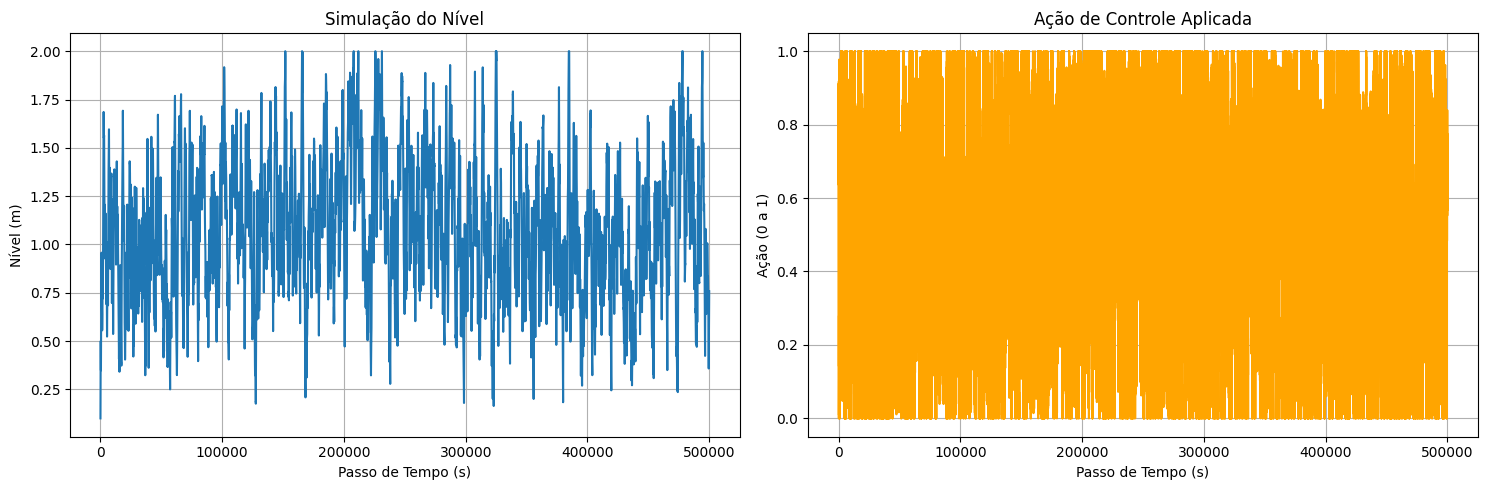

In [ ]:
# --- Gera√ß√£o do Dataset ---

N_PASSOS = 500000  # N√∫mero de passos de simula√ß√£o para gerar dados
h_inicial = 0.1   # N√≠vel inicial do tanque

# Listas para armazenar os dados
historico_h_atual = []
historico_acao = []
historico_h_proximo = []

h_atual = h_inicial

for i in range(N_PASSOS):
    # --- GERAR A√á√ÉO DO CONTROLADOR VARIADA ---
    # Para um bom treinamento, a a√ß√£o n√£o pode ser constante.
    # Vamos gerar valores aleat√≥rios e mudan√ßas bruscas.
    if i % 200 == 0:
      # A cada 200 passos, sorteia uma nova a√ß√£o base e a mant√©m por um tempo
      acao_atual = np.random.rand()

    # Adiciona um pequeno ru√≠do para mais variabilidade
    acao_com_ruido = acao_atual + np.random.normal(0, 0.05)
    acao_controlador = np.clip(acao_com_ruido, 0, 1)

    # Simula um passo para obter o pr√≥ximo n√≠vel
    h_proximo = simular_passo_tanque(h_atual, acao_controlador)

    # Armazena o trio de dados
    historico_h_atual.append(h_atual)
    historico_acao.append(acao_controlador)
    historico_h_proximo.append(h_proximo)

    # Atualiza o n√≠vel para a pr√≥xima itera√ß√£o
    h_atual = h_proximo

# --- Cria√ß√£o do DataFrame do Pandas ---
df_treinamento = pd.DataFrame({
    'nivel_atual': historico_h_atual,
    'acao_controlador': historico_acao,
    'nivel_proximo': historico_h_proximo
})

print("Tamanho do dataset gerado:", df_treinamento.shape)
print("\nAmostra do dataset:")
print(df_treinamento.head())

# --- Visualiza√ß√£o dos Dados Gerados ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df_treinamento['nivel_atual'], label='N√≠vel do Tanque (m)')
plt.title('Simula√ß√£o do N√≠vel')
plt.xlabel('Passo de Tempo (s)')
plt.ylabel('N√≠vel (m)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_treinamento['acao_controlador'], label='A√ß√£o do Controlador', color='orange')
plt.title('A√ß√£o de Controle Aplicada')
plt.xlabel('Passo de Tempo (s)')
plt.ylabel('A√ß√£o (0 a 1)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Exemplo de estrutura do modelo em Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(32, activation='relu', input_shape=[2]), # 2 entradas: nivel e acao
    Dense(32, activation='relu'),
    Dense(1) # 1 sa√≠da: pr√≥ximo n√≠vel
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = df_treinamento[['nivel_atual', 'acao_controlador']].values
y = df_treinamento[['nivel_proximo']].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Treinamento do modelo
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42,)
model.fit(X_train, y_train, epochs=300, batch_size=264*10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 5ms/step - loss: 0.0859 - val_loss: 1.2583e-04
Epoch 2/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 8.6957e-05 - val_loss: 3.4973e-05
Epoch 3/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - loss: 2.6204e-05 - val_loss: 1.3965e-05
Epoch 4/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - loss: 1.2066e-05 - val_loss: 7.9538e-06
Epoch 5/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 7ms/step - loss: 6.8259e-06 - val_loss: 5.0019e-06
Epoch 6/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 8ms/step - loss: 4.5379e-06 - val_loss: 3.6155e-06
Epoch 7/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step - loss: 3.3007e-06 - val_loss: 2.7222e-06
Epoch 8/300
152/152 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ


--- Iniciando Simula√ß√£o do Controle MPC OTIMIZADO ---
Passo de controle 1/99 - N√≠vel Atual: 0.500 m
Passo de controle 2/99 - N√≠vel Atual: 0.501 m - A√ß√£o: 0.50 m^3/s
Passo de controle 3/99 - N√≠vel Atual: 0.501 m - A√ß√£o: 0.50 m^3/s
Passo de controle 4/99 - N√≠vel Atual: 0.502 m - A√ß√£o: 0.50 m^3/s
Passo de controle 5/99 - N√≠vel Atual: 0.502 m - A√ß√£o: 0.50 m^3/s
Passo de controle 6/99 - N√≠vel Atual: 0.503 m - A√ß√£o: 0.50 m^3/s
Passo de controle 7/99 - N√≠vel Atual: 0.503 m - A√ß√£o: 0.50 m^3/s
Passo de controle 8/99 - N√≠vel Atual: 0.504 m - A√ß√£o: 0.50 m^3/s
Passo de controle 9/99 - N√≠vel Atual: 0.505 m - A√ß√£o: 0.50 m^3/s
Passo de controle 10/99 - N√≠vel Atual: 0.505 m - A√ß√£o: 0.50 m^3/s
Passo de controle 11/99 - N√≠vel Atual: 0.506 m - A√ß√£o: 0.50 m^3/s
Passo de controle 12/99 - N√≠vel Atual: 0.506 m - A√ß√£o: 0.50 m^3/s
Passo de controle 13/99 - N√≠vel Atual: 0.507 m - A√ß√£o: 0.50 m^3/s
Passo de controle 14/99 - N√≠vel Atual: 0.507 m - A√ß√£o: 0.50 m^3/s
Passo d

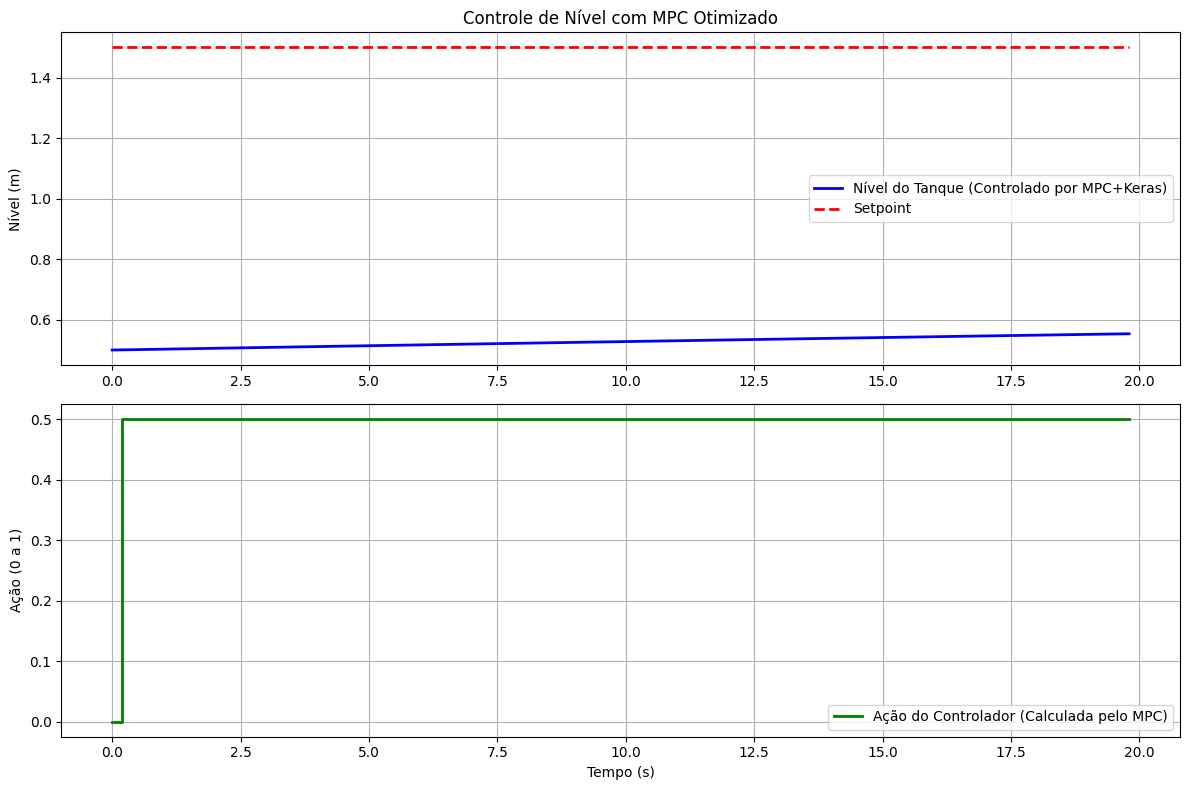

In [ ]:
from scipy.optimize import minimize
import tensorflow as tf
import time
@tf.function # Este decorador compila a fun√ß√£o para alta performance
def predict_step_compiled(model, input_data_scaled):
    # Usamos a chamada direta ao modelo, que √© mais eficiente dentro de tf.function
    return model(input_data_scaled, training=False)

def funcao_custo_mpc_keras_otimizada(acoes, h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y):
    custo_total = 0.0
    h_predito = tf.constant(h_atual, dtype=tf.float32) # Converter para Tensor

    for i in range(Np):
        acao_atual = tf.constant(acoes[i], dtype=tf.float32)

        # Prepara a entrada (como tensor)
        entrada_real = tf.reshape(tf.stack([h_predito, acao_atual]), (1, 2))

        # Normaliza usando as propriedades do scaler (convertido para tensores)
        scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32)
        min_X = tf.constant(scaler_X.min_, dtype=tf.float32)
        entrada_scaled = (entrada_real - min_X) * scale_X

        # Chama a fun√ß√£o compilada
        predicao_scaled = predict_step_compiled(model, entrada_scaled)

        # Desnormaliza
        scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32)
        min_y = tf.constant(scaler_y.min_, dtype=tf.float32)
        h_proximo_predito = (predicao_scaled / scale_y) + min_y

        h_predito = tf.squeeze(h_proximo_predito) # Remove dimens√µes extras

        # Calcula o custo
        custo_erro = we * (h_predito - h_setpoint)**2
        custo_acao = wu * (acao_atual)**2
        custo_total += custo_erro + custo_acao

    return float(custo_total) # Retorna um float para o Scipy

# ===================================================================
# PARTE 4: SIMULA√á√ÉO COM AS OTIMIZA√á√ïES
# ===================================================================
print("\n--- Iniciando Simula√ß√£o do Controle MPC OTIMIZADO ---")

# --- OTIMIZA√á√ÉO 2: AJUSTE DE PAR√ÇMETROS ---
Np = 15      # Reduzido de 15 para 10
we = 100.0
wu = 1.0
max_iter_optimizer = 500 # Limita o n√∫mero de itera√ß√µes do otimizador

N_SIM = 100; h_setpoint = 1.5; h_inicial = 0.5
hist_tempo = np.arange(N_SIM) * DELTA_T; hist_nivel = np.zeros(N_SIM); hist_acao = np.zeros(N_SIM); hist_setpoint = np.full(N_SIM, h_setpoint)
h_atual = h_inicial; hist_nivel[0] = h_atual

start_time = time.time()
for t in range(1, N_SIM):
    if t >1:
      print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m - A√ß√£o: {acao_aplicar:.2f} m^3/s")
    else:
      print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m")

    acoes_iniciais = np.ones(Np)*0.5
    bounds = [(0, 1)] * Np

    resultado_otimizacao = minimize(
        fun=funcao_custo_mpc_keras_otimizada, # Usando a nova fun√ß√£o
        x0=acoes_iniciais,
        args=(h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y),
        method='SLSQP',
        bounds=bounds,
        options={'maxiter': max_iter_optimizer} # Aplicando o limite de itera√ß√µes
    )

    acoes_otimas = resultado_otimizacao.x
    acao_aplicar = acoes_otimas[0]

    h_atual = simular_passo_tanque(h_atual, acao_aplicar)
    hist_nivel[t] = h_atual; hist_acao[t] = acao_aplicar

end_time = time.time()
print(f"\nSimula√ß√£o conclu√≠da em {end_time - start_time:.2f} segundos.")

# --- Visualiza√ß√£o dos Resultados Finais ---
plt.figure(figsize=(12, 8)); plt.subplot(2, 1, 1)
plt.plot(hist_tempo, hist_nivel, label='N√≠vel do Tanque (Controlado por MPC+Keras)', color='blue', linewidth=2)

plt.plot(hist_tempo, hist_setpoint, label='Setpoint', color='red', linestyle='--', linewidth=2)
plt.title('Controle de N√≠vel com MPC Otimizado')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_tempo, hist_acao, label='A√ß√£o do Controlador (Calculada pelo MPC)', color='green', drawstyle='steps-post', linewidth=2)
plt.ylabel('A√ß√£o (0 a 1)'); plt.xlabel('Tempo (s)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

##Tentativa Pyswarm 1

In [ ]:
!pip install pyswarms

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 104.1/104.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Otimizadores
import pyswarms as ps

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# ===================================================================
# PARTE 3: FUN√á√ÉO DE CUSTO OTIMIZADA COM @tf.function
# (Vamos usar a vers√£o r√°pida que falhou com o SciPy, mas que funcionar√° com o PSO)
# ===================================================================
@tf.function
def predict_step_compiled(model, input_data_scaled):
    return model(input_data_scaled, training=False)

def funcao_custo_mpc_keras_tf(acoes, h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y):
    # Esta √© a fun√ß√£o que calcula o custo para UMA sequ√™ncia de a√ß√µes (uma part√≠cula)
    custo_total = tf.constant(0.0, dtype=tf.float32)
    h_predito = tf.constant(h_atual, dtype=tf.float32)
    scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32); min_X = tf.constant(scaler_X.min_, dtype=tf.float32)
    scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32); min_y = tf.constant(scaler_y.min_, dtype=tf.float32)

    for i in range(Np):
        acao_atual = tf.constant(acoes[i], dtype=tf.float32)
        entrada_real = tf.reshape(tf.stack([h_predito, acao_atual]), (1, 2))
        entrada_scaled = (entrada_real - min_X) * scale_X
        predicao_scaled = predict_step_compiled(model, entrada_scaled)
        h_proximo_predito = (predicao_scaled / scale_y) + min_y
        h_predito = tf.squeeze(h_proximo_predito)
        custo_erro = we * (h_predito - h_setpoint)**2
        custo_acao = wu * (acao_atual)**2
        custo_total += custo_erro + custo_acao
    return custo_total.numpy() # Retorna um valor numpy/float

def pyswarms_cost_function_wrapper(x, h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y):
    # O PySwarms passa um array 'x' onde cada LINHA √© uma part√≠cula (uma sequ√™ncia de a√ß√µes)
    n_particles = x.shape[0]
    costs = np.zeros(n_particles)
    for i in range(n_particles):
        particle_actions = x[i]
        costs[i] = funcao_custo_mpc_keras_tf(
            particle_actions, h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y
        )
    return costs

# ===================================================================
# PARTE 4: SIMULA√á√ÉO DO CONTROLE COM MPC-PSO
# ===================================================================
print("\n--- Iniciando Simula√ß√£o do Controle MPC com PSO ---")

# Par√¢metros do MPC e PSO
Np = 10; we = 100.0; wu = 1.0
n_particles = 20 # N√∫mero de drones no esquadr√£o
pso_iters = 30   # Quantas "rodadas" de busca eles far√£o a cada passo de tempo
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} # Hiperpar√¢metros do PSO

N_SIM = 150; h_setpoint = 1.5; h_inicial = 0.1
hist_tempo = np.arange(N_SIM) * DELTA_T; hist_nivel = np.zeros(N_SIM); hist_acao = np.zeros(N_SIM); hist_setpoint = np.full(N_SIM, h_setpoint)
h_atual = h_inicial; hist_nivel[0] = h_atual

start_time = time.time()
for t in range(1, N_SIM):
    if t >1:
      print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m - A√ß√£o: {acao_aplicar:.2f} m^3/s")
    else:
      print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m")

    # Configura√ß√£o dos limites para as a√ß√µes (dimens√£o Np)
    lower_bound = np.zeros(Np)
    upper_bound = np.ones(Np)
    bounds = (lower_bound, upper_bound)

    # Cria o otimizador PSO
    optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=Np,
        options=options,
        bounds=bounds
    )

    # Executa a otimiza√ß√£o
    # Note que passamos os argumentos extras da fun√ß√£o de custo via um dicion√°rio kwargs
    cost, pos = optimizer.optimize(
        objective_func=pyswarms_cost_function_wrapper,
        iters=pso_iters,
        verbose=False,
        h_atual=h_atual, h_setpoint=h_setpoint, Np=Np, we=we, wu=wu,
        model=model, scaler_X=scaler_X, scaler_y=scaler_y
    )

    # A melhor sequ√™ncia de a√ß√µes encontrada √© 'pos'
    acao_aplicar = pos[0] # Pegamos a primeira a√ß√£o da melhor sequ√™ncia

    h_atual = simular_passo_tanque(h_atual, acao_aplicar)
    hist_nivel[t] = h_atual
    hist_acao[t] = acao_aplicar

end_time = time.time()
print(f"\nSimula√ß√£o com PSO conclu√≠da em {end_time - start_time:.2f} segundos.")

# (O c√≥digo de plotagem permanece o mesmo)
plt.figure(figsize=(12, 8)); plt.subplot(2, 1, 1); plt.plot(hist_tempo, hist_nivel, label='N√≠vel do Tanque (Controlado por MPC+PSO)', color='purple', linewidth=2); plt.plot(hist_tempo, hist_setpoint, label='Setpoint', color='red', linestyle='--', linewidth=2); plt.title('Controle de N√≠vel com MPC-PSO e @tf.function'); plt.ylabel('N√≠vel (m)'); plt.legend(); plt.grid(True); plt.subplot(2, 1, 2); plt.plot(hist_tempo, hist_acao, label='A√ß√£o do Controlador (Calculada pelo PSO)', color='orange', drawstyle='steps-post', linewidth=2); plt.ylabel('A√ß√£o (0 a 1)'); plt.xlabel('Tempo (s)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Modelo Keras Treinado ---

--- Iniciando Simula√ß√£o do Controle MPC com PSO ---
Passo de controle 1/149 - N√≠vel Atual: 0.100 m
Passo de controle 2/149 - N√≠vel Atual: 0.108 m
Passo de controle 3/149 - N√≠vel Atual: 0.118 m
Passo de controle 4/149 - N√≠vel Atual: 0.123 m
Passo de controle 5/149 - N√≠vel Atual: 0.132 m
Passo de controle 6/149 - N√≠vel Atual: 0.139 m
Passo de controle 7/149 - N√≠vel Atual: 0.148 m
Passo de controle 8/149 - N√≠vel Atual: 0.156 m
Passo de controle 9/149 - N√≠vel Atual: 0.163 m
Passo de controle 10/149 - N√≠vel Atual: 0.170 m
Passo de controle 11/149 - N√≠vel Atual: 0.178 m
Passo de controle 12/149 - N√≠vel Atual: 0.184 m
Passo de controle 13/149 - N√≠vel Atual: 0.192 m
Passo de controle 14/149 - N√≠vel Atual: 0.200 m
Passo de controle 15/149 - N√≠vel Atual: 0.207 m
Passo de controle 16/149 - N√≠vel Atual: 0.215 m
Passo de controle 17/149 - N√≠vel Atual: 0.222 m
Passo de controle 18/149 - N√≠vel Atual: 0.226 m
Passo de controle 19/149 - N√≠vel Atual: 0

KeyboardInterrupt: 

##Tentativa pyswarm 2

In [ ]:
from scipy.optimize import minimize
import tensorflow as tf
import time
@tf.function # Este decorador compila a fun√ß√£o para alta performance
def predict_step_compiled(model, input_data_scaled):
    # Usamos a chamada direta ao modelo, que √© mais eficiente dentro de tf.function
    return model(input_data_scaled, training=False)

def funcao_custo_mpc_keras_otimizada(acoes, h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y):
    custo_total = 0.0
    h_predito = tf.constant(h_atual, dtype=tf.float32) # Converter para Tensor

    for i in range(Np):
        acao_atual = tf.constant(acoes[i], dtype=tf.float32)

        # Prepara a entrada (como tensor)
        entrada_real = tf.reshape(tf.stack([h_predito, acao_atual]), (1, 2))

        # Normaliza usando as propriedades do scaler (convertido para tensores)
        scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32)
        min_X = tf.constant(scaler_X.min_, dtype=tf.float32)
        entrada_scaled = (entrada_real - min_X) * scale_X

        # Chama a fun√ß√£o compilada
        predicao_scaled = predict_step_compiled(model, entrada_scaled)

        # Desnormaliza
        scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32)
        min_y = tf.constant(scaler_y.min_, dtype=tf.float32)
        h_proximo_predito = (predicao_scaled / scale_y) + min_y

        h_predito = tf.squeeze(h_proximo_predito) # Remove dimens√µes extras

        # Calcula o custo
        custo_erro = we * (h_predito - h_setpoint)**2
        custo_acao = wu * (acao_atual)**2
        custo_total += custo_erro + custo_acao

    return float(custo_total) # Retorna um float para o Scipy

# ===================================================================
# PARTE 4: SIMULA√á√ÉO COM AS OTIMIZA√á√ïES
# ===================================================================
print("\n--- Iniciando Simula√ß√£o do Controle MPC OTIMIZADO ---")

# --- OTIMIZA√á√ÉO 2: AJUSTE DE PAR√ÇMETROS ---
Np = 15      # Reduzido de 15 para 10
we = 100.0
wu = 1.0
max_iter_optimizer = 500 # Limita o n√∫mero de itera√ß√µes do otimizador

N_SIM = 100; h_setpoint = 1.5; h_inicial = 0.5
hist_tempo = np.arange(N_SIM) * DELTA_T; hist_nivel = np.zeros(N_SIM); hist_acao = np.zeros(N_SIM); hist_setpoint = np.full(N_SIM, h_setpoint)
h_atual = h_inicial; hist_nivel[0] = h_atual

start_time = time.time()
for t in range(1, N_SIM):
    if t >1:
      print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m - A√ß√£o: {acao_aplicar:.2f} m^3/s")
    else:
      print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m")

    acoes_iniciais = np.ones(Np)*0.5
    bounds = [(0, 1)] * Np

    resultado_otimizacao = minimize(
        fun=funcao_custo_mpc_keras_otimizada, # Usando a nova fun√ß√£o
        x0=acoes_iniciais,
        args=(h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y),
        method='SLSQP',
        bounds=bounds,
        options={'maxiter': max_iter_optimizer} # Aplicando o limite de itera√ß√µes
    )

    acoes_otimas = resultado_otimizacao.x
    acao_aplicar = acoes_otimas[0]

    h_atual = simular_passo_tanque(h_atual, acao_aplicar)
    hist_nivel[t] = h_atual; hist_acao[t] = acao_aplicar

end_time = time.time()
print(f"\nSimula√ß√£o conclu√≠da em {end_time - start_time:.2f} segundos.")

# --- Visualiza√ß√£o dos Resultados Finais ---
plt.figure(figsize=(12, 8)); plt.subplot(2, 1, 1)
plt.plot(hist_tempo, hist_nivel, label='N√≠vel do Tanque (Controlado por MPC+Keras)', color='blue', linewidth=2)

plt.plot(hist_tempo, hist_setpoint, label='Setpoint', color='red', linestyle='--', linewidth=2)
plt.title('Controle de N√≠vel com MPC Otimizado')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_tempo, hist_acao, label='A√ß√£o do Controlador (Calculada pelo MPC)', color='green', drawstyle='steps-post', linewidth=2)
plt.ylabel('A√ß√£o (0 a 1)'); plt.xlabel('Tempo (s)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

##Tentativa com hold 10s

2025-08-22 19:06:32,785 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



--- Iniciando Simula√ß√£o do Controle MPC-PSO com Hold de 10s ---
Passo de controle 1/749 - N√≠vel Atual: 1.000 m


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=1.03e+3
2025-08-22 19:06:38,440 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1033.1441650390625, best pos: [1.30663153]
2025-08-22 19:06:38,449 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.307
Passo de controle 11/749 - N√≠vel Atual: 1.019 m - A√ß√£o: 1.31 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=982
2025-08-22 19:06:43,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 982.0955810546875, best pos: [1.24379484]
2025-08-22 19:06:43,849 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.244
Passo de controle 21/749 - N√≠vel Atual: 1.038 m - A√ß√£o: 1.24 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=980
2025-08-22 19:06:48,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 980.25927734375, best pos: [1.25419956]
2025-08-22 19:06:48,424 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.254
Passo de controle 31/749 - N√≠vel Atual: 1.057 m - A√ß√£o: 1.25 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=970
2025-08-22 19:06:53,430 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 969.5886840820312, best pos: [1.04131643]
2025-08-22 19:06:53,444 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.041
Passo de controle 41/749 - N√≠vel Atual: 1.076 m - A√ß√£o: 1.04 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=931
2025-08-22 19:06:58,799 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 930.5992431640625, best pos: [1.03467596]
2025-08-22 19:06:58,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.035
Passo de controle 51/749 - N√≠vel Atual: 1.095 m - A√ß√£o: 1.03 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=1.09e+3
2025-08-22 19:07:03,410 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1092.0701904296875, best pos: [0.70833379]
2025-08-22 19:07:03,417 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.708
Passo de controle 61/749 - N√≠vel Atual: 1.102 m - A√ß√£o: 0.71 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=954
2025-08-22 19:07:08,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 954.2388305664062, best pos: [1.25374503]
2025-08-22 19:07:08,855 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.254
Passo de controle 71/749 - N√≠vel Atual: 1.120 m - A√ß√£o: 1.25 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=813
2025-08-22 19:07:13,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 813.1386108398438, best pos: [1.11323649]
2025-08-22 19:07:13,410 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.113
Passo de controle 81/749 - N√≠vel Atual: 1.139 m - A√ß√£o: 1.11 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=837
2025-08-22 19:07:18,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 837.3757934570312, best pos: [0.9406776]
2025-08-22 19:07:18,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.941
Passo de controle 91/749 - N√≠vel Atual: 1.154 m - A√ß√£o: 0.94 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=756
2025-08-22 19:07:23,842 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 755.7655029296875, best pos: [1.08683782]
2025-08-22 19:07:23,852 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.087
Passo de controle 101/749 - N√≠vel Atual: 1.172 m - A√ß√£o: 1.09 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=718
2025-08-22 19:07:28,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 717.6408081054688, best pos: [1.11371116]
2025-08-22 19:07:28,438 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.114
Passo de controle 111/749 - N√≠vel Atual: 1.190 m - A√ß√£o: 1.11 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=742
2025-08-22 19:07:33,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 742.4659423828125, best pos: [0.92816145]
2025-08-22 19:07:33,892 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.928
Passo de controle 121/749 - N√≠vel Atual: 1.205 m - A√ß√£o: 0.93 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=705
2025-08-22 19:07:38,537 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 704.8603515625, best pos: [0.9521343]
2025-08-22 19:07:38,546 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.952
Passo de controle 131/749 - N√≠vel Atual: 1.221 m - A√ß√£o: 0.95 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=647
2025-08-22 19:07:43,098 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 647.1986083984375, best pos: [1.04782796]
2025-08-22 19:07:43,106 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.048
Passo de controle 141/749 - N√≠vel Atual: 1.238 m - A√ß√£o: 1.05 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=612
2025-08-22 19:07:48,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 611.9204711914062, best pos: [1.08475031]
2025-08-22 19:07:48,560 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.085
Passo de controle 151/749 - N√≠vel Atual: 1.255 m - A√ß√£o: 1.08 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=624
2025-08-22 19:07:53,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 623.89111328125, best pos: [1.11721908]
2025-08-22 19:07:53,233 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.117
Passo de controle 161/749 - N√≠vel Atual: 1.272 m - A√ß√£o: 1.12 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=617
2025-08-22 19:07:58,346 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 616.7159423828125, best pos: [0.88606904]
2025-08-22 19:07:58,355 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.886
Passo de controle 171/749 - N√≠vel Atual: 1.285 m - A√ß√£o: 0.89 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=591
2025-08-22 19:08:03,222 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 591.3931884765625, best pos: [0.89838041]
2025-08-22 19:08:03,230 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.898
Passo de controle 181/749 - N√≠vel Atual: 1.298 m - A√ß√£o: 0.90 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=627
2025-08-22 19:08:07,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 626.5252685546875, best pos: [0.77274087]
2025-08-22 19:08:07,854 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.773
Passo de controle 191/749 - N√≠vel Atual: 1.306 m - A√ß√£o: 0.77 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=533
2025-08-22 19:08:13,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 533.4332275390625, best pos: [0.97819801]
2025-08-22 19:08:13,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.978
Passo de controle 201/749 - N√≠vel Atual: 1.321 m - A√ß√£o: 0.98 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=515
2025-08-22 19:08:17,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 514.73486328125, best pos: [0.96495409]
2025-08-22 19:08:17,996 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.965
Passo de controle 211/749 - N√≠vel Atual: 1.337 m - A√ß√£o: 0.96 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=487
2025-08-22 19:08:22,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 486.8984375, best pos: [0.99643021]
2025-08-22 19:08:22,790 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.996
Passo de controle 221/749 - N√≠vel Atual: 1.353 m - A√ß√£o: 1.00 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=557
2025-08-22 19:08:27,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 557.0761108398438, best pos: [0.72623871]
2025-08-22 19:08:27,888 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.726
Passo de controle 231/749 - N√≠vel Atual: 1.359 m - A√ß√£o: 0.73 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=504
2025-08-22 19:08:32,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 503.99407958984375, best pos: [0.83329635]
2025-08-22 19:08:32,428 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.833
Passo de controle 241/749 - N√≠vel Atual: 1.368 m - A√ß√£o: 0.83 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=587
2025-08-22 19:08:38,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 586.9694213867188, best pos: [0.62216158]
2025-08-22 19:08:38,353 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.622
Passo de controle 251/749 - N√≠vel Atual: 1.370 m - A√ß√£o: 0.62 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=489
2025-08-22 19:08:42,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 488.70257568359375, best pos: [0.82974918]
2025-08-22 19:08:42,862 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.830
Passo de controle 261/749 - N√≠vel Atual: 1.380 m - A√ß√£o: 0.83 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=431
2025-08-22 19:08:47,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 430.98431396484375, best pos: [1.01558654]
2025-08-22 19:08:47,442 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.016
Passo de controle 271/749 - N√≠vel Atual: 1.396 m - A√ß√£o: 1.02 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=414
2025-08-22 19:08:52,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 414.45770263671875, best pos: [1.0066257]
2025-08-22 19:08:52,892 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.007
Passo de controle 281/749 - N√≠vel Atual: 1.412 m - A√ß√£o: 1.01 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=418
2025-08-22 19:08:57,441 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 417.9839172363281, best pos: [0.88740237]
2025-08-22 19:08:57,450 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.887
Passo de controle 291/749 - N√≠vel Atual: 1.423 m - A√ß√£o: 0.89 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=451
2025-08-22 19:09:02,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 450.97943115234375, best pos: [0.72924601]
2025-08-22 19:09:02,935 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.729
Passo de controle 301/749 - N√≠vel Atual: 1.429 m - A√ß√£o: 0.73 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=381
2025-08-22 19:09:07,505 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 380.75, best pos: [1.00602992]
2025-08-22 19:09:07,513 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.006
Passo de controle 311/749 - N√≠vel Atual: 1.444 m - A√ß√£o: 1.01 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=370
2025-08-22 19:09:12,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 369.83209228515625, best pos: [0.96101017]
2025-08-22 19:09:12,068 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.961
Passo de controle 321/749 - N√≠vel Atual: 1.458 m - A√ß√£o: 0.96 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=413
2025-08-22 19:09:17,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 413.21484375, best pos: [0.70662203]
2025-08-22 19:09:17,470 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.707
Passo de controle 331/749 - N√≠vel Atual: 1.463 m - A√ß√£o: 0.71 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=362
2025-08-22 19:09:22,026 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 361.97674560546875, best pos: [0.88287203]
2025-08-22 19:09:22,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.883
Passo de controle 341/749 - N√≠vel Atual: 1.473 m - A√ß√£o: 0.88 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=349
2025-08-22 19:09:27,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 348.9124450683594, best pos: [0.89613511]
2025-08-22 19:09:27,113 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.896
Passo de controle 351/749 - N√≠vel Atual: 1.485 m - A√ß√£o: 0.90 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=367
2025-08-22 19:09:32,177 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 367.28643798828125, best pos: [0.74914938]
2025-08-22 19:09:32,186 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.749
Passo de controle 361/749 - N√≠vel Atual: 1.490 m - A√ß√£o: 0.75 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=370
2025-08-22 19:09:36,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 370.1065368652344, best pos: [0.7183891]
2025-08-22 19:09:36,833 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.718
Passo de controle 371/749 - N√≠vel Atual: 1.495 m - A√ß√£o: 0.72 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=327
2025-08-22 19:09:42,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 326.65252685546875, best pos: [0.91508339]
2025-08-22 19:09:42,340 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.915
Passo de controle 381/749 - N√≠vel Atual: 1.507 m - A√ß√£o: 0.92 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=318
2025-08-22 19:09:47,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 317.5085754394531, best pos: [0.8997119]
2025-08-22 19:09:47,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.900
Passo de controle 391/749 - N√≠vel Atual: 1.518 m - A√ß√£o: 0.90 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=305
2025-08-22 19:09:52,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 305.33197021484375, best pos: [0.97956375]
2025-08-22 19:09:52,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.980
Passo de controle 401/749 - N√≠vel Atual: 1.532 m - A√ß√£o: 0.98 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=295
2025-08-22 19:09:57,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 295.0967712402344, best pos: [0.93794717]
2025-08-22 19:09:57,253 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.938
Passo de controle 411/749 - N√≠vel Atual: 1.545 m - A√ß√£o: 0.94 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=363
2025-08-22 19:10:01,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 363.23199462890625, best pos: [1.05046177]
2025-08-22 19:10:01,888 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.050
Passo de controle 421/749 - N√≠vel Atual: 1.559 m - A√ß√£o: 1.05 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=278
2025-08-22 19:10:07,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 278.4221496582031, best pos: [0.85095834]
2025-08-22 19:10:07,372 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.851
Passo de controle 431/749 - N√≠vel Atual: 1.568 m - A√ß√£o: 0.85 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=382
2025-08-22 19:10:11,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 381.95703125, best pos: [1.06607222]
2025-08-22 19:10:11,968 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 1.066
Passo de controle 441/749 - N√≠vel Atual: 1.583 m - A√ß√£o: 1.07 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=262
2025-08-22 19:10:16,765 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 262.2182922363281, best pos: [0.83911495]
2025-08-22 19:10:16,773 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.839
Passo de controle 451/749 - N√≠vel Atual: 1.591 m - A√ß√£o: 0.84 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=257
2025-08-22 19:10:22,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 256.6097106933594, best pos: [0.92374923]
2025-08-22 19:10:22,132 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.924
Passo de controle 461/749 - N√≠vel Atual: 1.603 m - A√ß√£o: 0.92 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=255
2025-08-22 19:10:26,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 254.68492126464844, best pos: [0.97227987]
2025-08-22 19:10:26,668 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.972
Passo de controle 471/749 - N√≠vel Atual: 1.616 m - A√ß√£o: 0.97 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=246
2025-08-22 19:10:32,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 245.639892578125, best pos: [0.76752407]
2025-08-22 19:10:32,079 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.768
Passo de controle 481/749 - N√≠vel Atual: 1.621 m - A√ß√£o: 0.77 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=250
2025-08-22 19:10:36,636 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 250.32810974121094, best pos: [0.99570296]
2025-08-22 19:10:36,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.996
Passo de controle 491/749 - N√≠vel Atual: 1.635 m - A√ß√£o: 1.00 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=233
2025-08-22 19:10:41,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 232.7778778076172, best pos: [0.77626293]
2025-08-22 19:10:41,290 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.776
Passo de controle 501/749 - N√≠vel Atual: 1.641 m - A√ß√£o: 0.78 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=228
2025-08-22 19:10:46,781 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 228.27879333496094, best pos: [0.85002874]
2025-08-22 19:10:46,790 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.850
Passo de controle 511/749 - N√≠vel Atual: 1.649 m - A√ß√£o: 0.85 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=224
2025-08-22 19:10:51,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 223.95916748046875, best pos: [0.82983854]
2025-08-22 19:10:51,551 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.830
Passo de controle 521/749 - N√≠vel Atual: 1.657 m - A√ß√£o: 0.83 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=220
2025-08-22 19:10:57,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 220.34068298339844, best pos: [0.81662891]
2025-08-22 19:10:57,018 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.817
Passo de controle 531/749 - N√≠vel Atual: 1.664 m - A√ß√£o: 0.82 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=254
2025-08-22 19:11:01,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 254.08493041992188, best pos: [0.54900547]
2025-08-22 19:11:01,792 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.549
Passo de controle 541/749 - N√≠vel Atual: 1.660 m - A√ß√£o: 0.55 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=219
2025-08-22 19:11:06,513 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 218.62672424316406, best pos: [0.80521269]
2025-08-22 19:11:06,522 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.805
Passo de controle 551/749 - N√≠vel Atual: 1.667 m - A√ß√£o: 0.81 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=221
2025-08-22 19:11:12,114 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 220.51390075683594, best pos: [0.89149486]
2025-08-22 19:11:12,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.891
Passo de controle 561/749 - N√≠vel Atual: 1.677 m - A√ß√£o: 0.89 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=212
2025-08-22 19:11:16,800 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 212.2157440185547, best pos: [0.82638531]
2025-08-22 19:11:16,811 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.826
Passo de controle 571/749 - N√≠vel Atual: 1.684 m - A√ß√£o: 0.83 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=209
2025-08-22 19:11:22,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 208.51528930664062, best pos: [0.79577287]
2025-08-22 19:11:22,390 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.796
Passo de controle 581/749 - N√≠vel Atual: 1.690 m - A√ß√£o: 0.80 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=220
2025-08-22 19:11:27,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 219.68370056152344, best pos: [0.92923243]
2025-08-22 19:11:27,165 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.929
Passo de controle 591/749 - N√≠vel Atual: 1.701 m - A√ß√£o: 0.93 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=203
2025-08-22 19:11:31,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 202.86231994628906, best pos: [0.72434235]
2025-08-22 19:11:31,907 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.724
Passo de controle 601/749 - N√≠vel Atual: 1.704 m - A√ß√£o: 0.72 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=202
2025-08-22 19:11:37,455 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 201.7974090576172, best pos: [0.80660569]
2025-08-22 19:11:37,464 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.807
Passo de controle 611/749 - N√≠vel Atual: 1.710 m - A√ß√£o: 0.81 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=204
2025-08-22 19:11:42,254 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 204.0065460205078, best pos: [0.85241593]
2025-08-22 19:11:42,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.852
Passo de controle 621/749 - N√≠vel Atual: 1.718 m - A√ß√£o: 0.85 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=344
2025-08-22 19:11:47,844 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 344.274658203125, best pos: [0.21855434]
2025-08-22 19:11:47,853 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.219
Passo de controle 631/749 - N√≠vel Atual: 1.702 m - A√ß√£o: 0.22 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=205
2025-08-22 19:11:52,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 204.90113830566406, best pos: [0.84044749]
2025-08-22 19:11:52,633 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.840
Passo de controle 641/749 - N√≠vel Atual: 1.709 m - A√ß√£o: 0.84 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=202
2025-08-22 19:11:57,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 202.04014587402344, best pos: [0.68960142]
2025-08-22 19:11:57,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.690
Passo de controle 651/749 - N√≠vel Atual: 1.711 m - A√ß√£o: 0.69 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=199
2025-08-22 19:12:03,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 198.7014617919922, best pos: [0.78884673]
2025-08-22 19:12:03,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.789
Passo de controle 661/749 - N√≠vel Atual: 1.716 m - A√ß√£o: 0.79 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=197
2025-08-22 19:12:07,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 197.37039184570312, best pos: [0.71082048]
2025-08-22 19:12:07,727 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.711
Passo de controle 671/749 - N√≠vel Atual: 1.719 m - A√ß√£o: 0.71 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=213
2025-08-22 19:12:13,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 212.86778259277344, best pos: [0.91816606]
2025-08-22 19:12:13,245 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.918
Passo de controle 681/749 - N√≠vel Atual: 1.729 m - A√ß√£o: 0.92 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=198
2025-08-22 19:12:17,867 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 197.9549560546875, best pos: [0.83550326]
2025-08-22 19:12:17,877 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.836
Passo de controle 691/749 - N√≠vel Atual: 1.736 m - A√ß√£o: 0.84 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=213
2025-08-22 19:12:22,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 212.57373046875, best pos: [0.92367349]
2025-08-22 19:12:22,494 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.924
Passo de controle 701/749 - N√≠vel Atual: 1.747 m - A√ß√£o: 0.92 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=187
2025-08-22 19:12:27,917 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 187.47665405273438, best pos: [0.69349856]
2025-08-22 19:12:27,926 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.693
Passo de controle 711/749 - N√≠vel Atual: 1.748 m - A√ß√£o: 0.69 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=189
2025-08-22 19:12:32,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 188.63026428222656, best pos: [0.6586676]
2025-08-22 19:12:32,627 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.659
Passo de controle 721/749 - N√≠vel Atual: 1.749 m - A√ß√£o: 0.66 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=186
2025-08-22 19:12:37,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 186.4016876220703, best pos: [0.73697548]
2025-08-22 19:12:37,787 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.737
Passo de controle 731/749 - N√≠vel Atual: 1.752 m - A√ß√£o: 0.74 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=198
2025-08-22 19:12:42,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 197.6443634033203, best pos: [0.85465586]
2025-08-22 19:12:42,700 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Nova a√ß√£o calculada: 0.855
Passo de controle 741/749 - N√≠vel Atual: 1.760 m - A√ß√£o: 0.85 m^3/s


pyswarms.single.global_best: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|1/1, best_cost=184
2025-08-22 19:12:47,249 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 183.55807495117188, best pos: [0.70748339]


Nova a√ß√£o calculada: 0.707

Simula√ß√£o com Hold conclu√≠da em 374.48 segundos.


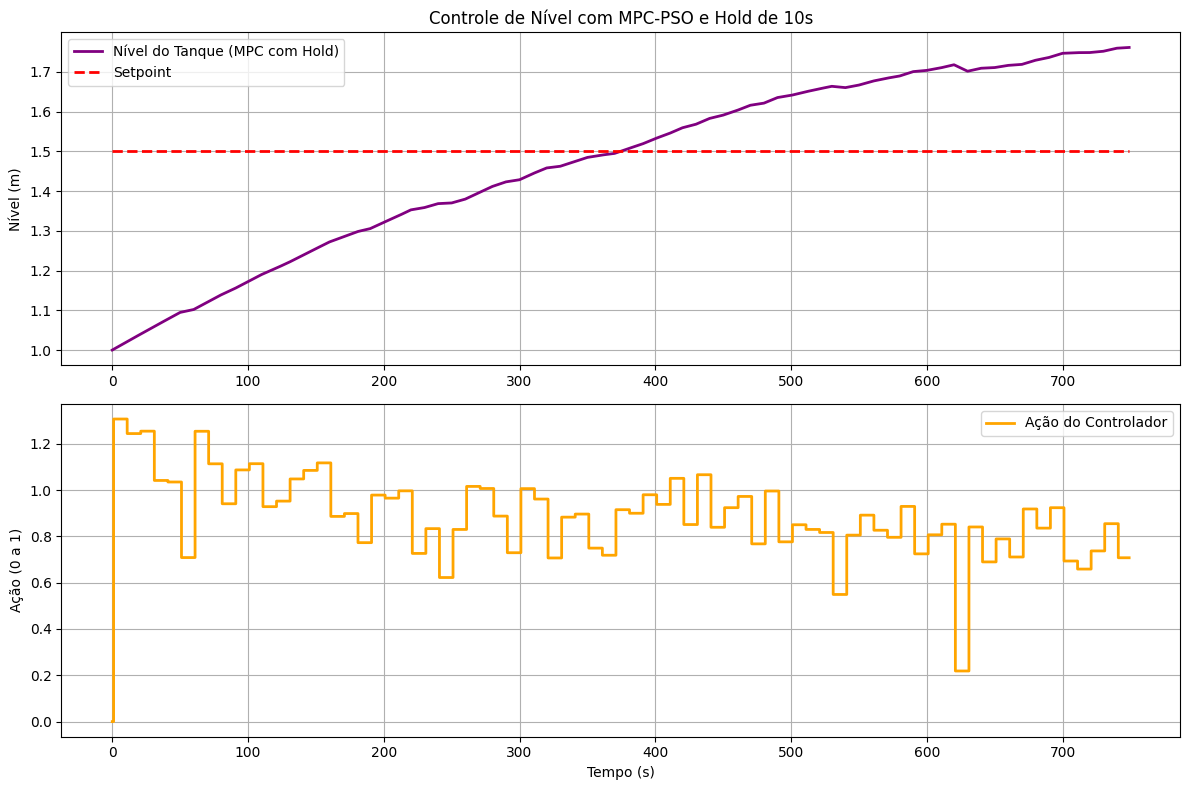

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Otimizadores
import pyswarms as ps

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# ===================================================================
# PARTE 3: FUN√á√ÉO DE CUSTO MODIFICADA PARA O "HOLD"
# ===================================================================
@tf.function
def predict_step_compiled(model, input_data_scaled):
    return model(input_data_scaled, training=False)

def funcao_custo_mpc_hold(acao_unica, h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y):
    # Esta fun√ß√£o recebe apenas UMA a√ß√£o e a simula por Np passos
    custo_total = tf.constant(0.0, dtype=tf.float32)
    h_predito = tf.constant(h_atual, dtype=tf.float32)
    # A a√ß√£o √© constante durante toda a predi√ß√£o
    acao_a_ser_mantida = tf.constant(acao_unica[0], dtype=tf.float32)

    scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32); min_X = tf.constant(scaler_X.min_, dtype=tf.float32)
    scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32); min_y = tf.constant(scaler_y.min_, dtype=tf.float32)

    for i in range(Np):
        # USA A MESMA A√á√ÉO EM TODOS OS PASSOS
        entrada_real = tf.reshape(tf.stack([h_predito, acao_a_ser_mantida]), (1, 2))
        entrada_scaled = (entrada_real - min_X) * scale_X
        predicao_scaled = predict_step_compiled(model, entrada_scaled)
        h_proximo_predito = (predicao_scaled / scale_y) + min_y
        h_predito = tf.squeeze(h_proximo_predito)
        custo_erro = we * (h_predito - h_setpoint)**2
        custo_acao = wu * (acao_a_ser_mantida)**2
        custo_total += custo_erro + custo_acao
    return custo_total.numpy()

def pyswarms_cost_function_wrapper_hold(x, h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y):
    # Agora 'x' √© um array onde cada linha √© uma part√≠cula com UMA dimens√£o
    n_particles = x.shape[0]
    costs = np.zeros(n_particles)
    for i in range(n_particles):
        # x[i] √© um array com um elemento, ex: [0.75]
        costs[i] = funcao_custo_mpc_hold(
            x[i], h_atual, h_setpoint, Np, we, wu, model, scaler_X, scaler_y
        )
    return costs

# ===================================================================
# PARTE 4: SIMULA√á√ÉO DO CONTROLE COM "HOLD" DE 10 SEGUNDOS
# ===================================================================
print("\n--- Iniciando Simula√ß√£o do Controle MPC-PSO com Hold de 10s ---")

# Par√¢metros do MPC e PSO
PERIODO_HOLD = 10 # <<<<<<< NOVO PAR√ÇMETRO (em segundos)
Np = 200; we = 10.0; wu = 1.0 # Horizonte de predi√ß√£o > per√≠odo de hold
n_particles = 10; pso_iters = 1
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

N_SIM = int(750); h_setpoint = 1.5; h_inicial = 1
hist_tempo = np.arange(N_SIM) * 1; hist_nivel = np.zeros(N_SIM); hist_acao = np.zeros(N_SIM); hist_setpoint = np.full(N_SIM, h_setpoint)
h_atual = h_inicial; hist_nivel[0] = h_atual
acao_a_aplicar = 0.0 # A√ß√£o inicial

start_time = time.time()
for t in range(1, N_SIM):
    # --- L√ìGICA DO HOLD: S√ì OTIMIZA A CADA 10 SEGUNDOS ---
    if (t - 1) % PERIODO_HOLD == 0:
      if t >1:
        print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m - A√ß√£o: {acao_a_aplicar:.2f} m^3/s")
      else:
        print(f"Passo de controle {t}/{N_SIM-1} - N√≠vel Atual: {h_atual:.3f} m")

      # --- MUDAN√áA IMPORTANTE: A dimens√£o da busca agora √© 1 ---
      DIMENSOES_BUSCA = 1
      bounds = (np.zeros(DIMENSOES_BUSCA), np.ones(DIMENSOES_BUSCA)*2)

      optimizer = ps.single.GlobalBestPSO(
          n_particles=n_particles,
          dimensions=DIMENSOES_BUSCA, # <<<<<<< MUDOU PARA 1
          options=options,
          bounds=bounds
      )

      cost, pos = optimizer.optimize(
          objective_func=pyswarms_cost_function_wrapper_hold,
          iters=pso_iters,
          verbose=True,
          h_atual=h_atual, h_setpoint=h_setpoint, Np=Np, we=we, wu=wu,
          model=model, scaler_X=scaler_X, scaler_y=scaler_y
      )

      # A melhor posi√ß√£o 'pos' √© a √∫nica a√ß√£o a ser aplicada
      acao_a_aplicar = pos[0]
      print(f"Nova a√ß√£o calculada: {acao_a_aplicar:.3f}")

    # A simula√ß√£o do tanque continua a cada segundo, usando a √∫ltima a√ß√£o calculada
    h_atual = simular_passo_tanque(h_atual, acao_a_aplicar)

    # Guarda os resultados
    hist_nivel[t] = h_atual
    hist_acao[t] = acao_a_aplicar

end_time = time.time()
print(f"\nSimula√ß√£o com Hold conclu√≠da em {end_time - start_time:.2f} segundos.")

# --- Visualiza√ß√£o dos Resultados ---
# A visualiza√ß√£o √© a mesma, mas o gr√°fico da a√ß√£o ficar√° em "degraus"
plt.figure(figsize=(12, 8));
plt.subplot(2, 1, 1);
plt.plot(hist_tempo, hist_nivel, label='N√≠vel do Tanque (MPC com Hold)', color='purple', linewidth=2);
plt.plot(hist_tempo, hist_setpoint, label='Setpoint', color='red', linestyle='--', linewidth=2);
plt.title(f'Controle de N√≠vel com MPC-PSO e Hold de {PERIODO_HOLD}s');
plt.ylabel('N√≠vel (m)'); plt.legend(); plt.grid(True);

plt.subplot(2, 1, 2);
# Usar 'steps-post' para visualizar claramente o efeito do hold
plt.plot(hist_tempo, hist_acao, label='A√ß√£o do Controlador', color='orange', drawstyle='steps-post', linewidth=2);
plt.ylabel('A√ß√£o (0 a 1)'); plt.xlabel('Tempo (s)'); plt.legend(); plt.grid(True);

plt.tight_layout();
plt.show()

#Dados

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# --- Par√¢metros F√≠sicos do Sistema de 4 Tanques (em unidades do SI) ---

# Acelera√ß√£o da gravidade (m/s¬≤)
g = 9.81

# √Åreas das se√ß√µes transversais dos tanques (A_i) em m¬≤
# Convertido de cm¬≤ para m¬≤ (1 m¬≤ = 10000 cm¬≤)
A1 = 28e-4
A2 = 32e-4
A3 = 28e-4
A4 = 32e-4

# √Åreas das se√ß√µes transversais dos orif√≠cios de sa√≠da (a_i) em m¬≤
a1 = 0.071e-4
a2 = 0.057e-4
a3 = 0.071e-4
a4 = 0.057e-4

# Par√¢metros das v√°lvulas (adimensionais) do ponto P-
gamma1 = 0.70
gamma2 = 0.60

# Constantes das bombas (k_i) em m¬≥/s/V
# Calculadas a partir do ponto de opera√ß√£o P-
# (k_i * v_i^0) [cm¬≥/s] / v_i^0 [V] * (1e-6 [m¬≥/cm¬≥])
k1 = (3.33 / 3.00) * 1e-6
k2 = (3.35 / 3.00) * 1e-6

# --- Par√¢metros de Simula√ß√£o ---
DELTA_T = 1.0  # Passo de tempo da simula√ß√£o (s). 1.0 segundo.
ALTURA_MAX_TANQUE = 1.0 # Altura m√°xima em metros (1m), para clipping
VOLTAGEM_MAX = 24.0     # Voltagem m√°xima de entrada para as bombas (V)

# Ponto de opera√ß√£o P- em metros
h0_P_minus = np.array([12.4e-2, 12.7e-2])
v0_P_minus = np.array([3.00, 3.00])

In [ ]:
from scipy.integrate import solve_ivp
def modelo_quadruplo_tanque(t, h, v1, v2):
    h1, h2, h3, h4 = h

    # Prote√ß√£o contra valores negativos (raiz de n√∫meros negativos)
    h1 = max(h1, 0)
    h2 = max(h2, 0)
    h3 = max(h3, 0)
    h4 = max(h4, 0)

    dh1_dt = (-(a1/A1) * np.sqrt(2*g*h1) +
              (a3/A1) * np.sqrt(2*g*h3) +
              (gamma1*k1/A1) * v1)

    dh2_dt = (-(a2/A2) * np.sqrt(2*g*h2) +
              (a4/A2) * np.sqrt(2*g*h4) +
              (gamma2*k2/A2) * v2)

    dh3_dt = (-(a3/A3) * np.sqrt(2*g*h3) +
              ((1 - gamma2)*k2/A3) * v2)

    dh4_dt = (-(a4/A4) * np.sqrt(2*g*h4) +
              ((1 - gamma1)*k1/A4) * v1)

    return [dh1_dt, dh2_dt, dh3_dt, dh4_dt]

# üß© Simulador com solve_ivp (1 passo)
def simular_passo_quadruplo(h_atuais, acoes_controle, delta_t=DELTA_T):
    """
    Usa solve_ivp para simular o sistema por um passo (delta_t segundos).
    """
    v1 = np.clip(acoes_controle[0], 0, VOLTAGEM_MAX)
    v2 = np.clip(acoes_controle[1], 0, VOLTAGEM_MAX)

    sol = solve_ivp(
        modelo_quadruplo_tanque,
        t_span=[0, delta_t],
        y0=h_atuais,
        args=(v1, v2),
        method='RK45',  # M√©todo padr√£o de Runge-Kutta 4(5)
        t_eval=[delta_t]  # S√≥ queremos o valor no final do passo
    )

    h_prox = sol.y[:, -1]
    h_prox = np.clip(h_prox, 0, ALTURA_MAX_TANQUE)

    return h_prox

Iniciando gera√ß√£o de dados...
Gera√ß√£o de dados conclu√≠da.

Tamanho do dataset gerado: (300000, 10)

Amostra do dataset:
   h1_atual  h2_atual  h3_atual  h4_atual         v1        v2  h1_proximo  \
0  0.100000  0.100000  0.050000  0.050000  12.900883  12.50544    0.102511   
1  0.102511  0.101872  0.049490  0.049582  12.900883  12.50544    0.104966   
2  0.104966  0.103714  0.048992  0.049171  12.900883  12.50544    0.107366   
3  0.107366  0.105526  0.048507  0.048768  12.900883  12.50544    0.109713   
4  0.109713  0.107310  0.048035  0.048371  12.900883  12.50544    0.112009   

   h2_proximo  h3_proximo  h4_proximo  
0    0.101872    0.049490    0.049582  
1    0.103714    0.048992    0.049171  
2    0.105526    0.048507    0.048768  
3    0.107310    0.048035    0.048371  
4    0.109065    0.047574    0.047982  


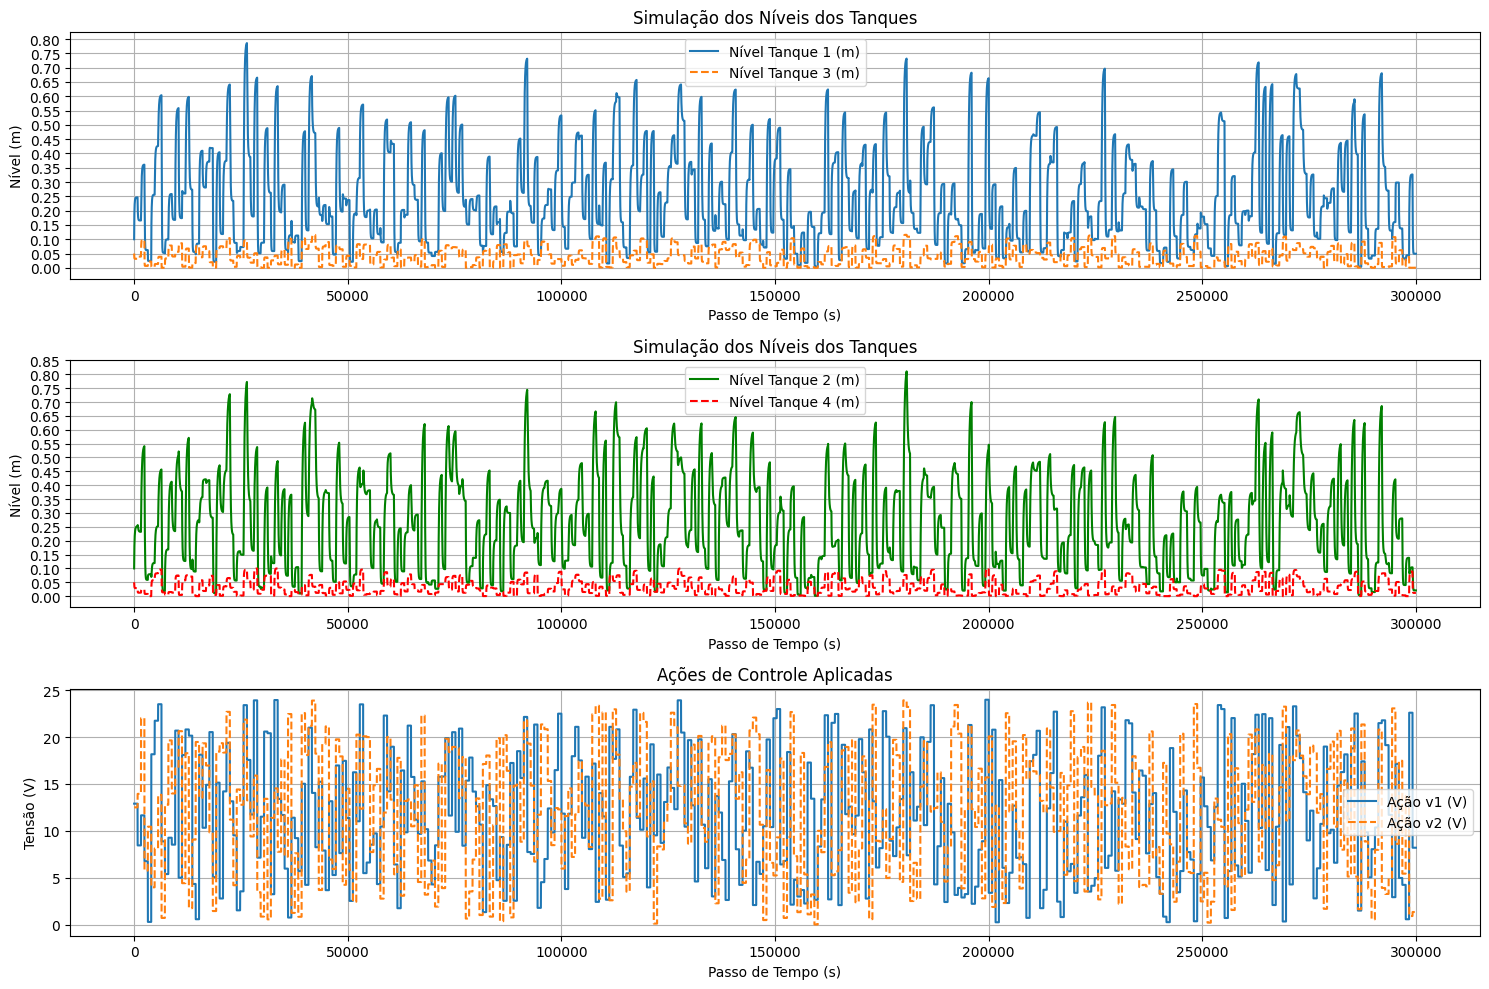

In [ ]:
# --- Gera√ß√£o do Dataset ---

N_PASSOS = 300000  # N√∫mero de passos de simula√ß√£o
# N√≠veis iniciais (em metros), um pouco abaixo do ponto de opera√ß√£o
h_atuais = np.array([0.10, 0.10, 0.05, 0.05])

# Listas para armazenar os dados
historico_h_atuais = []
historico_acoes = []
historico_h_proximos = []

# A√ß√µes de controle iniciais
v_atuais = np.array([3.0, 3.0])

print("Iniciando gera√ß√£o de dados...")

for i in range(N_PASSOS):
    # --- GERAR A√á√ïES DE CONTROLE VARIADAS ---
    # A cada 400 passos, sorteia uma nova a√ß√£o base e a mant√©m por um tempo
    if i % 800 == 0:
        v_base = np.random.uniform(low=0.0, high=24, size=2)

    # Adiciona um pequeno ru√≠do gaussiano para mais variabilidade
    # v_com_ruido = v_base + np.random.normal(0, 0.1, size=2)
    # acoes_controle = np.clip(v_com_ruido, 0, VOLTAGEM_MAX)
    acoes_controle = v_base

    # Simula um passo para obter o pr√≥ximo n√≠vel
    h_proximos = simular_passo_quadruplo(h_atuais, acoes_controle)

    # Armazena o trio de dados (estado atual, a√ß√£o, pr√≥ximo estado)
    historico_h_atuais.append(h_atuais)
    historico_acoes.append(acoes_controle)
    historico_h_proximos.append(h_proximos)

    # Atualiza o n√≠vel para a pr√≥xima itera√ß√£o
    h_atuais = h_proximos

print("Gera√ß√£o de dados conclu√≠da.")

# --- Cria√ß√£o do DataFrame do Pandas ---
# Convertendo listas de arrays em arrays 2D
h_atuais_arr = np.array(historico_h_atuais)
acoes_arr = np.array(historico_acoes)
h_proximos_arr = np.array(historico_h_proximos)

df_treinamento = pd.DataFrame({
    'h1_atual': h_atuais_arr[:, 0],
    'h2_atual': h_atuais_arr[:, 1],
    'h3_atual': h_atuais_arr[:, 2],
    'h4_atual': h_atuais_arr[:, 3],
    'v1': acoes_arr[:, 0],
    'v2': acoes_arr[:, 1],
    'h1_proximo': h_proximos_arr[:, 0],
    'h2_proximo': h_proximos_arr[:, 1],
    'h3_proximo': h_proximos_arr[:, 2],
    'h4_proximo': h_proximos_arr[:, 3]
})

print("\nTamanho do dataset gerado:", df_treinamento.shape)
print("\nAmostra do dataset:")
print(df_treinamento.head())

# --- Visualiza√ß√£o dos Dados Gerados ---

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(df_treinamento.index, df_treinamento['h1_atual'], label='N√≠vel Tanque 1 (m)')
plt.plot(df_treinamento.index, df_treinamento['h3_atual'], label='N√≠vel Tanque 3 (m)', linestyle='--')
plt.title('Simula√ß√£o dos N√≠veis dos Tanques')
plt.xlabel('Passo de Tempo (s)')
plt.ylabel('N√≠vel (m)')
plt.grid(True)
plt.legend()

ax2 = plt.subplot(3, 1, 2)
plt.plot(df_treinamento.index, df_treinamento['h2_atual'], label='N√≠vel Tanque 2 (m)', color='green')
plt.plot(df_treinamento.index, df_treinamento['h4_atual'], label='N√≠vel Tanque 4 (m)', linestyle='--', color='red')
plt.title('Simula√ß√£o dos N√≠veis dos Tanques')
plt.xlabel('Passo de Tempo (s)')
plt.ylabel('N√≠vel (m)')
plt.grid(True)
plt.legend()

ax3 = plt.subplot(3, 1, 3)
plt.plot(df_treinamento.index, df_treinamento['v1'], label='A√ß√£o v1 (V)')
plt.plot(df_treinamento.index, df_treinamento['v2'], label='A√ß√£o v2 (V)', linestyle='--')
plt.title('A√ß√µes de Controle Aplicadas')
plt.xlabel('Passo de Tempo (s)')
plt.ylabel('Tens√£o (V)')
plt.grid(True)
plt.legend()

# ticks de 0.5 em 0.5 para todos
for ax in (ax1, ax2):
    ax.yaxis.set_major_locator(MultipleLocator(0.05))

plt.tight_layout()
plt.show()

#Tentativa modelo de 4 tanques Rede neural Densa

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# O modelo LSTM seria mais √∫til se tiv√©ssemos sequ√™ncias,
# mas para um preditor de passo √∫nico (one-step-ahead), uma Rede Neural Densa (MLP) √© suficiente e mais r√°pida.
# Vamos seguir a estrutura do seu exemplo que usa Dense layers.
model = Sequential([
    # 6 entradas: h1, h2, h3, h4, v1, v2
    Dense(64, activation='relu', input_shape=[6]),
    Dense(64, activation='relu'),
    # 4 sa√≠das: h1_prox, h2_prox, h3_prox, h4_prox
    Dense(4)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --- Prepara√ß√£o dos dados para o modelo ---
X_cols = ['h1_atual', 'h2_atual', 'h3_atual', 'h4_atual', 'v1', 'v2']
y_cols = ['h1_proximo', 'h2_proximo', 'h3_proximo', 'h4_proximo']

X = df_treinamento[X_cols].values
y = df_treinamento[y_cols].values

# Criar e treinar os normalizadores
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Divis√£o em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Treinamento do modelo
print("\nIniciando treinamento do modelo...")
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    verbose=1,
    validation_data=(X_test, y_test)
)
end_time = time.time()
print(f"\nTreinamento conclu√≠do em {end_time - start_time:.2f} segundos.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense_8 (Dense)                 ‚îÇ (None, 64)             ‚îÇ           448 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                 ‚îÇ (None, 64)             ‚îÇ         4,160 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                ‚îÇ (None, 4)              ‚îÇ           260 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,868 (19.02 KB)

 Trainable params: 4,868 (19.02 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento do modelo...
Epoch 1/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 4ms/step - loss: 0.0132 - val_loss: 3.7147e-05
Epoch 2/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - loss: 2.8484e-05 - val_loss: 1.3634e-05
Epoch 3/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 5ms/step - loss: 1.1800e-05 - val_loss: 7.6825e-06
Epoch 4/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 4ms/step - loss: 6.9518e-06 - val_loss: 5.0834e-06
Epoch 5/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - loss: 4.9008e-06 - val_loss: 4.0833e-06
Epoch 6/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 4ms/step - loss: 3.7349e-06 - val_loss: 3.1694e-06
Epoch 7/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 5ms/step - loss: 3.4650e-06 - val_loss: 4.3632e-06
Epoch 8/100
469/469 ‚îÅ

In [ ]:
@tf.function
def predict_step_compiled_mimo(model, input_data_scaled):
    return model(input_data_scaled, training=False)

def funcao_custo_mpc_mimo(acoes_futuras, h_atuais, h_setpoints, Np, we, wu, model, scaler_X, scaler_y):
    """
    Fun√ß√£o de custo para o MPC do sistema de 4 tanques.
    Otimiza um par de a√ß√µes [v1, v2] que ser√° mantido por Np passos.
    """
    custo_total = tf.constant(0.0, dtype=tf.float32)
    h_preditos = tf.constant(h_atuais, dtype=tf.float32)

    # Otimizamos um par de a√ß√µes [v1, v2] que ser√° mantido constante
    v1, v2 = acoes_futuras[0], acoes_futuras[1]
    acoes_constantes = tf.constant([v1, v2], dtype=tf.float32)

    # Converte os scalers para tensores para uso dentro do tf.function
    scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32)
    min_X = tf.constant(scaler_X.min_, dtype=tf.float32)
    scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32)
    min_y = tf.constant(scaler_y.min_, dtype=tf.float32)

    # Pesos do erro (maior para o tanque 1, por exemplo)
    we1, we2 = we[0], we[1]
    wu1, wu2 = wu[0], wu[1]

    # Setpoints para os tanques 1 e 2
    h1_sp, h2_sp = h_setpoints[0], h_setpoints[1]

    for _ in range(Np):
        h1, h2, h3, h4 = h_preditos[0], h_preditos[1], h_preditos[2], h_preditos[3]

        # Monta o vetor de entrada para o modelo
        entrada_real = tf.reshape(tf.stack([h1, h2, h3, h4, v1, v2]), (1, 6))

        # Normaliza a entrada
        entrada_scaled = (entrada_real - min_X) * scale_X

        # Faz a predi√ß√£o com o modelo de rede neural
        predicao_scaled = predict_step_compiled_mimo(model, entrada_scaled)

        # Desnormaliza a sa√≠da para obter os n√≠veis em metros
        h_proximos_preditos = (predicao_scaled / scale_y) + min_y
        h_preditos = tf.squeeze(h_proximos_preditos)
        # print(f"N√≠veis preditos: {h_preditos[0]}")
        # Calcula o custo do erro (apenas para os tanques 1 e 2)
        erro_h1 = h_preditos[0] - h1_sp
        erro_h2 = h_preditos[1] - h2_sp
        custo_erro = we1 * erro_h1**2 + we2 * erro_h2**2

        # Calcula o custo da a√ß√£o de controle
        custo_acao = wu1 * v1**2 + wu2 * v2**2

        custo_total += custo_erro + custo_acao*custo_erro

    return custo_total.numpy()

In [ ]:
def otimizador_grid_search(grid_passos, bounds, h_atuais, h_setpoints, Np, we, wu, model, scaler_X, scaler_y):
    """
    Encontra a melhor a√ß√£o de controle [v1, v2] usando uma busca exaustiva em grade.

    Args:
        grid_passos (int): N√∫mero de pontos a serem testados em cada dimens√£o (v1 e v2).
        bounds (tuple): Tupla com os limites (min_bounds, max_bounds) para as a√ß√µes.
        ... (demais argumentos da fun√ß√£o de custo)

    Returns:
        tuple: (custo_minimo, melhor_acao)
    """
    v_min = bounds[0][0] # Limite inferior para v1 e v2
    v_max = bounds[1][0] # Limite superior para v1 e v2

    # Cria os vetores de valores a serem testados para v1 e v2
    v1_range = np.linspace(v_min, v_max, grid_passos)
    v2_range = np.linspace(v_min, v_max, grid_passos)

    custo_minimo = np.inf
    melhor_acao = np.array([0.0, 0.0])

    # Loop aninhado para testar todas as combina√ß√µes
    for v1_teste in v1_range:
        for v2_teste in v2_range:
            acao_atual = np.array([v1_teste, v2_teste])

            # Calcula o custo para a combina√ß√£o atual
            custo = funcao_custo_mpc_mimo(
                acao_atual, h_atuais, h_setpoints, Np, we, wu,
                model, scaler_X, scaler_y
            )
            # print(f"Custo para a√ß√£o {np.round(acao_atual,2)}: {custo:.2g}")

            # Se o custo for menor que o m√≠nimo encontrado at√© agora, atualiza
            if custo < custo_minimo:
                custo_minimo = custo
                melhor_acao = acao_atual

    return custo_minimo, melhor_acao


--- Iniciando Simula√ß√£o do Controle MPC com Grid Search ---

Passo de controle 1/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.100, 0.100] m
Nova a√ß√£o calculada: [v1=12.421, v2=11.263] V (Custo: 44)

Passo de controle 11/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.121, 0.115] m
Nova a√ß√£o calculada: [v1=2.000, v2=5.474] V (Custo: 30)

Passo de controle 21/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.110, 0.115] m
Nova a√ß√£o calculada: [v1=11.263, v2=19.368] V (Custo: 77)

Passo de controle 31/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.124, 0.141] m
Nova a√ß√£o calculada: [v1=13.579, v2=12.421] V (Custo: 21)

Passo de controle 41/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.143, 0.151] m
Nova a√ß√£o calculada: [v1=12.421, v2=6.632] V (Custo: 5)

Passo de controle 51/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.155, 0.148] m
Nova a√ß√£o calculada: [v1=7.789, v2=8.947] V (Custo: 

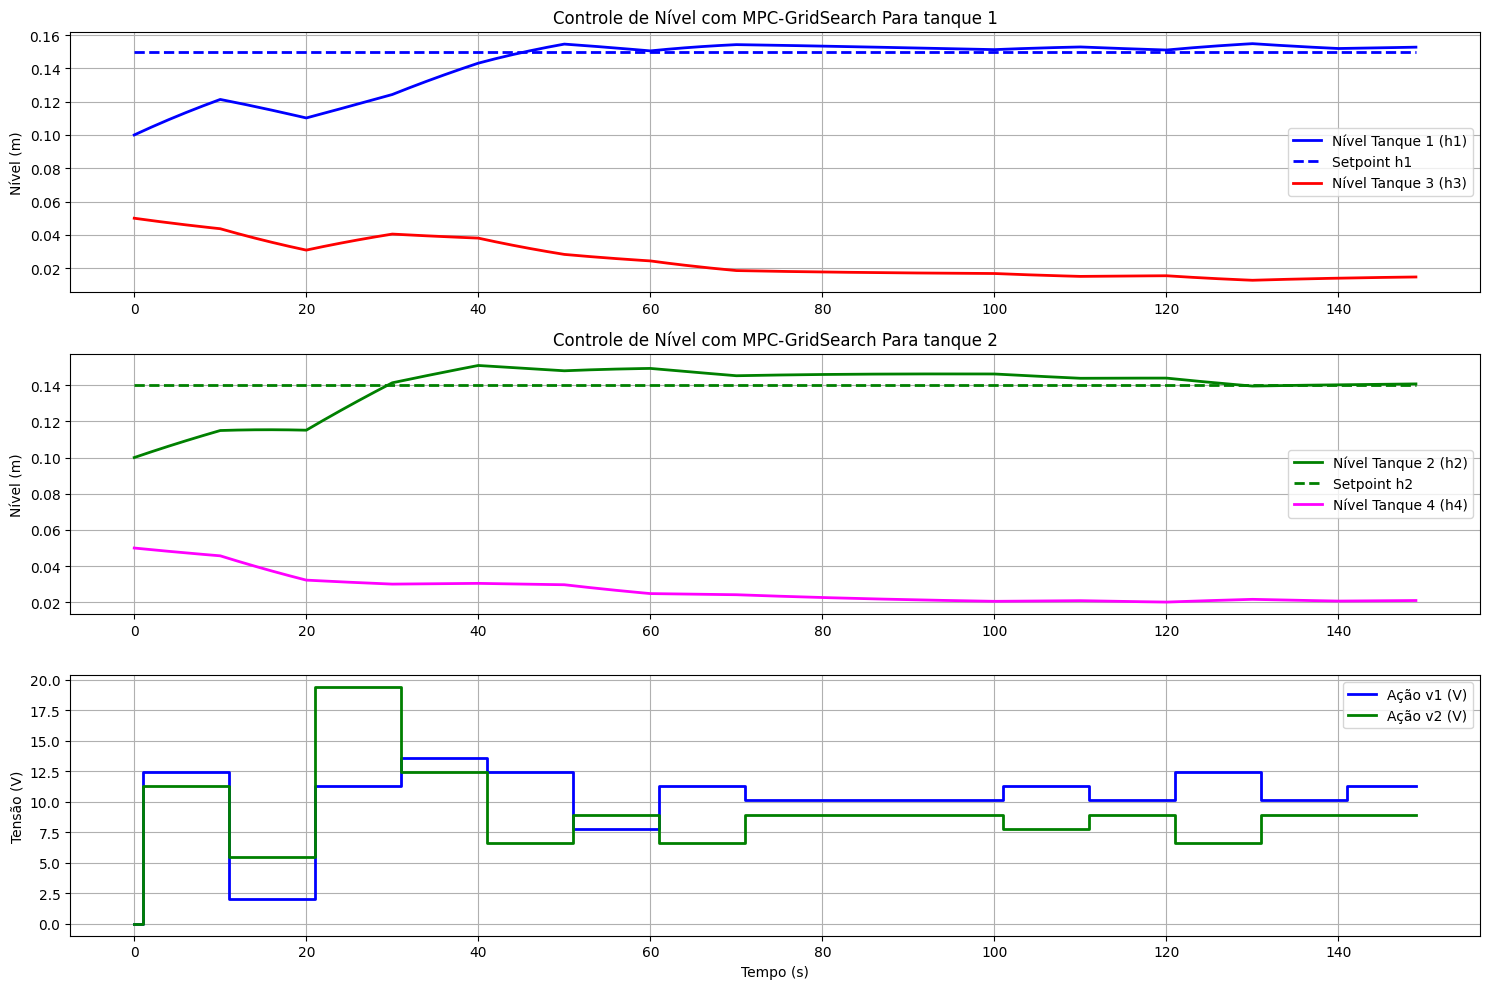

In [ ]:
import time
# ===================================================================
# SIMULA√á√ÉO DO CONTROLE MPC-GRID_SEARCH PARA O SISTEMA DE 4 TANQUES
# ===================================================================
print("\n--- Iniciando Simula√ß√£o do Controle MPC com Grid Search ---")

# --- Par√¢metros do MPC e da Busca ---
PERIODO_HOLD = 10      # Otimizar a cada 10 segundos
Np = 20               # Horizonte de predi√ß√£o
we = np.array([6e3, 6e3]) # Pesos para os erros de h1 e h2
wu = np.array([1e-3, 1e-3])   # Pesos para o custo das a√ß√µes v1 e v2

# Par√¢metros do Grid Search
GRID_PASSOS = 20 #Testar√° 20x20 = 400 combina√ß√µes.
DIMENSOES_BUSCA = 2
bounds = (np.ones(DIMENSOES_BUSCA)*2, np.full(DIMENSOES_BUSCA, VOLTAGEM_MAX))


# --- Condi√ß√µes da Simula√ß√£o (id√™nticas √† anterior) ---
N_SIM = 150 # Simular por 300 segundos
h_setpoints = np.array([0.15, 0.14]) # SP para h1 = 15cm, SP para h2 = 14cm
h_atuais = np.array([0.10, 0.10, 0.05, 0.05])

# Hist√≥rico para plotagem
hist_tempo = np.arange(N_SIM) * DELTA_T
hist_niveis = np.zeros((N_SIM, 4))
hist_acoes = np.zeros((N_SIM, 2))
hist_setpoints = np.tile(h_setpoints, (N_SIM, 1))

hist_niveis[0, :] = h_atuais
acoes_a_aplicar = v0_P_minus

start_time = time.time()
for t in range(1, N_SIM):
    # --- L√ìGICA DO HOLD: Otimiza apenas em intervalos definidos ---
    if (t - 1) % PERIODO_HOLD == 0:
        print(f"\nPasso de controle {t}/{N_SIM-1}. Otimizando com Grid Search...")
        print(f"N√≠veis Atuais (h1,h2): [{h_atuais[0]:.3f}, {h_atuais[1]:.3f}] m")

        cost, pos = otimizador_grid_search(
            grid_passos=GRID_PASSOS,
            bounds=bounds,
            h_atuais=h_atuais,
            h_setpoints=h_setpoints,
            Np=Np, we=we, wu=wu, model=model,
            scaler_X=scaler_X, scaler_y=scaler_y
        )

        # A melhor posi√ß√£o 'pos' √© o vetor [v1, v2] a ser aplicado
        acoes_a_aplicar = pos
        print(f"Nova a√ß√£o calculada: [v1={acoes_a_aplicar[0]:.3f}, v2={acoes_a_aplicar[1]:.3f}] V (Custo: {cost:.2g})")


    # A simula√ß√£o do tanque continua a cada segundo, usando a √∫ltima a√ß√£o calculada
    #poderia usar a pr√≥pria info da rede neural, mas dessa forma estamos fingindo que √© o sinal emitido pela instrumenta√ß√£o
    h_atuais = simular_passo_quadruplo(h_atuais, acoes_a_aplicar)

    # Guarda os resultados
    hist_niveis[t, :] = h_atuais
    hist_acoes[t, :] = acoes_a_aplicar

end_time = time.time()
print(f"\nSimula√ß√£o com Grid Search conclu√≠da em {end_time - start_time:.2f} segundos.")

# 1. Calcular os sinais de erro para os tanques controlados (h1 e h2)
erro_h1 = hist_setpoints[:, 0] - hist_niveis[:, 0]
erro_h2 = hist_setpoints[:, 1] - hist_niveis[:, 1]

# 2. Calcular cada m√©trica para cada tanque
# M√©trica = Soma(termo) * passo_de_tempo
iae_h1 = np.sum(np.abs(erro_h1)) * DELTA_T
ise_h1 = np.sum(erro_h1**2) * DELTA_T
itae_h1 = np.sum(hist_tempo * np.abs(erro_h1)) * DELTA_T
itse_h1 = np.sum(hist_tempo * (erro_h1**2)) * DELTA_T

iae_h2 = np.sum(np.abs(erro_h2)) * DELTA_T
ise_h2 = np.sum(erro_h2**2) * DELTA_T
itae_h2 = np.sum(hist_tempo * np.abs(erro_h2)) * DELTA_T
itse_h2 = np.sum(hist_tempo * (erro_h2**2)) * DELTA_T

# 3. Exibir os resultados de forma organizada
print("\n--- M√©tricas de Performance do Controlador ---")
print("----------------------------------------------")
print(f"M√©tricas para o Tanque 1 (h1):")
print(f"  IAE  (Integral Absolute Error)      = {iae_h1:.4f}")
print(f"  ISE  (Integral Squared Error)       = {ise_h1:.4f}")
print(f"  ITAE (Integral Time Abs Error)   = {itae_h1:.4f}")
print(f"  ITSE (Integral Time Squared Error) = {itse_h1:.4f}")
print("----------------------------------------------")
print(f"M√©tricas para o Tanque 2 (h2):")
print(f"  IAE  (Integral Absolute Error)      = {iae_h2:.4f}")
print(f"  ISE  (Integral Squared Error)       = {ise_h2:.4f}")
print(f"  ITAE (Integral Time Abs Error)   = {itae_h2:.4f}")
print(f"  ITSE (Integral Time Squared Error) = {itse_h2:.4f}")
print("----------------------------------------------")


# Visualiza√ß√£o
plt.figure(figsize=(15, 10))

# Gr√°fico dos n√≠veis dos tanques inferiores
plt.subplot(3, 1, 1)
plt.plot(hist_tempo, hist_niveis[:, 0], label='N√≠vel Tanque 1 (h1)', color='blue', linewidth=2)
plt.plot(hist_tempo, hist_setpoints[:, 0], label='Setpoint h1', color='blue', linestyle='--', linewidth=2)
plt.plot(hist_tempo, hist_niveis[:, 2], label='N√≠vel Tanque 3 (h3)', color='red', linewidth=2)
plt.title('Controle de N√≠vel com MPC-GridSearch Para tanque 1')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

# Gr√°fico 2 (no meio): N√≠veis dos tanques superiores (n√£o controlados)
plt.subplot(3, 1, 2)
plt.plot(hist_tempo, hist_niveis[:, 1], label='N√≠vel Tanque 2 (h2)', color='green', linewidth=2)
plt.plot(hist_tempo, hist_setpoints[:, 1], label='Setpoint h2', color='green', linestyle='--', linewidth=2)
plt.plot(hist_tempo, hist_niveis[:, 3], label='N√≠vel Tanque 4 (h4)', color='magenta', linewidth=2)
plt.title('Controle de N√≠vel com MPC-GridSearch Para tanque 2')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

# Gr√°fico das a√ß√µes de controle
plt.subplot(3, 1, 3)
plt.plot(hist_tempo, hist_acoes[:, 0], label='A√ß√£o v1 (V)', color='blue', drawstyle='steps-post', linewidth=2)
plt.plot(hist_tempo, hist_acoes[:, 1], label='A√ß√£o v2 (V)', color='green', drawstyle='steps-post', linewidth=2)
plt.ylabel('Tens√£o (V)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Teste RCC

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Hiperpar√¢metro que define o tamanho da "mem√≥ria" da RNN
SEQUENCE_LENGTH = 10

# --- Prepara√ß√£o dos dados para o modelo ---
def create_sequences(X_data, y_data, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - sequence_length):
        X_seq.append(X_data[i:(i + sequence_length)])
        y_seq.append(y_data[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

# --- Prepara√ß√£o dos dados para o modelo RNN ---
X_cols = ['h1_atual', 'h2_atual', 'h3_atual', 'h4_atual', 'v1', 'v2']
y_cols = ['h1_proximo', 'h2_proximo', 'h3_proximo', 'h4_proximo']
X_flat = df_treinamento[X_cols].values
y_flat = df_treinamento[y_cols].values
scaler_X = MinMaxScaler(); scaler_y = MinMaxScaler()
X_flat_scaled = scaler_X.fit_transform(X_flat)
y_flat_scaled = scaler_y.fit_transform(y_flat)

print(f"\nCriando sequ√™ncias com tamanho {SEQUENCE_LENGTH}...")
X_seq, y_seq = create_sequences(X_flat_scaled, y_flat_scaled, SEQUENCE_LENGTH)
print("Shape das sequ√™ncias de entrada (X):", X_seq.shape)
print("Shape das sa√≠das (y):", y_seq.shape)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

model_RNN = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(SEQUENCE_LENGTH, X_seq.shape[2])),
    Dense(32, activation='relu'),
    Dense(4)
])

model_RNN.compile(optimizer='adam', loss='mean_squared_error')
model_RNN.summary()

# Treinamento do modelo
print("\nIniciando treinamento do modelo...")
start_time = time.time()
history = model_RNN.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    verbose=1,
    validation_data=(X_test, y_test)
)
end_time = time.time()
print(f"\nTreinamento conclu√≠do em {end_time - start_time:.2f} segundos.")


Criando sequ√™ncias com tamanho 10...
Shape das sequ√™ncias de entrada (X): (299990, 10, 6)
Shape das sa√≠das (y): (299990, 4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ simple_rnn (SimpleRNN)          ‚îÇ (None, 64)             ‚îÇ         4,544 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                ‚îÇ (None, 4)              ‚îÇ           132 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 6,756 (26.39 KB)

 Trainable params: 6,756 (26.39 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento do modelo...
Epoch 1/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 17ms/step - loss: 0.0119 - val_loss: 4.4412e-05
Epoch 2/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 18ms/step - loss: 3.5338e-05 - val_loss: 2.2877e-05
Epoch 3/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 14ms/step - loss: 1.9753e-05 - val_loss: 3.2181e-05
Epoch 4/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 20ms/step - loss: 1.5579e-05 - val_loss: 1.1086e-05
Epoch 5/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 27ms/step - loss: 1.1862e-05 - val_loss: 1.3941e-05
Epoch 6/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 16ms/step - loss: 1.0265e-05 - val_loss: 7.6798e-06
Epoch 7/100
469/469 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 23ms/step - loss: 9.0683e-06 - val_loss: 6.9137e-06
Epoch 8/100


In [ ]:
@tf.function
def predict_step_compiled_rnn(model, input_sequence_scaled):
    return model(input_sequence_scaled, training=False)

def funcao_custo_mpc_rnn(acoes_futuras, historico_sequencial, h_setpoints, Np, we, wu, model, scaler_X, scaler_y):
    """
    Fun√ß√£o de custo para o MPC com modelo RNN.
    Usa uma janela deslizante para prever Np passos no futuro.
    """
    custo_total = tf.constant(0.0, dtype=tf.float32)

    # A sequ√™ncia inicial de inputs normalizados
    sequencia_atual_scaled = tf.constant(historico_sequencial, dtype=tf.float32)

    v1, v2 = acoes_futuras[0], acoes_futuras[1]

    # Converte os scalers para tensores
    scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32)
    min_X = tf.constant(scaler_X.min_, dtype=tf.float32)
    scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32)
    min_y = tf.constant(scaler_y.min_, dtype=tf.float32)

    we1, we2 = we[0], we[1]
    wu1, wu2 = wu[0], wu[1]
    h1_sp, h2_sp = h_setpoints[0], h_setpoints[1]

    for _ in range(Np):
        # A entrada para o modelo √© a sequ√™ncia completa
        # O formato j√° √© (1, sequence_length, features), ent√£o adicionamos um eixo
        entrada_modelo = tf.expand_dims(sequencia_atual_scaled, axis=0)

        # 1. FAZ A PREDI√á√ÉO
        predicao_scaled = predict_step_compiled_rnn(model, entrada_modelo)

        # 2. DESNORMALIZA A SA√çDA
        h_proximos_preditos = (predicao_scaled / scale_y) + min_y
        h_preditos = tf.squeeze(h_proximos_preditos)

        # 3. CALCULA O CUSTO PARA ESTE PASSO
        erro_h1 = h_preditos[0] - h1_sp
        erro_h2 = h_preditos[1] - h2_sp
        custo_erro = we1 * erro_h1**2 + we2 * erro_h2**2
        custo_acao = wu1 * v1**2 + wu2 * v2**2
        custo_total += custo_erro + custo_acao*custo_erro

        # 4. ATUALIZA A SEQU√äNCIA PARA A PR√ìXIMA PREDI√á√ÉO (JANELA DESLIZANTE)
        # Cria o novo vetor de features com os n√≠veis preditos e as a√ß√µes constantes
        novo_vetor_features = tf.stack([h_preditos[0], h_preditos[1], h_preditos[2], h_preditos[3], v1, v2])
        novo_vetor_scaled = (novo_vetor_features - min_X) * scale_X

        # Adiciona o novo vetor e remove o mais antigo
        sequencia_atual_scaled = tf.concat([sequencia_atual_scaled[1:], [novo_vetor_scaled]], axis=0)

    return custo_total.numpy()

In [ ]:
def otimizador_grid_search_rnn(grid_passos, bounds, historico_sequencial, h_setpoints, Np, we, wu, model, scaler_X, scaler_y):
    v_min = bounds[0][0]
    v_max = bounds[1][0]
    v1_range = np.linspace(v_min, v_max, grid_passos)
    v2_range = np.linspace(v_min, v_max, grid_passos)
    custo_minimo = np.inf
    melhor_acao = np.array([0.0, 0.0])

    for v1_teste in v1_range:
        for v2_teste in v2_range:
            acao_atual = np.array([v1_teste, v2_teste])
            custo = funcao_custo_mpc_rnn(
                acao_atual, historico_sequencial, h_setpoints, Np, we, wu, model, scaler_X, scaler_y
            )
            if custo < custo_minimo:
                custo_minimo = custo
                melhor_acao = acao_atual
    return custo_minimo, melhor_acao


--- Iniciando Simula√ß√£o do Controle MPC com Grid Search ---

Passo de controle 1/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.100, 0.100] m
Nova a√ß√£o calculada: [v1=3.158, v2=10.105] V (Custo: 15)

Passo de controle 11/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.097, 0.112] m
Nova a√ß√£o calculada: [v1=6.632, v2=2.000] V (Custo: 15)

Passo de controle 21/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.101, 0.104] m
Nova a√ß√£o calculada: [v1=13.579, v2=24.000] V (Custo: 1.2e+02)

Passo de controle 31/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.122, 0.141] m
Nova a√ß√£o calculada: [v1=10.105, v2=13.579] V (Custo: 17)

Passo de controle 41/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.133, 0.152] m
Nova a√ß√£o calculada: [v1=12.421, v2=7.789] V (Custo: 6.3)

Passo de controle 51/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.147, 0.151] m
Nova a√ß√£o calculada: [v1=12.421, v2=6.632] V (

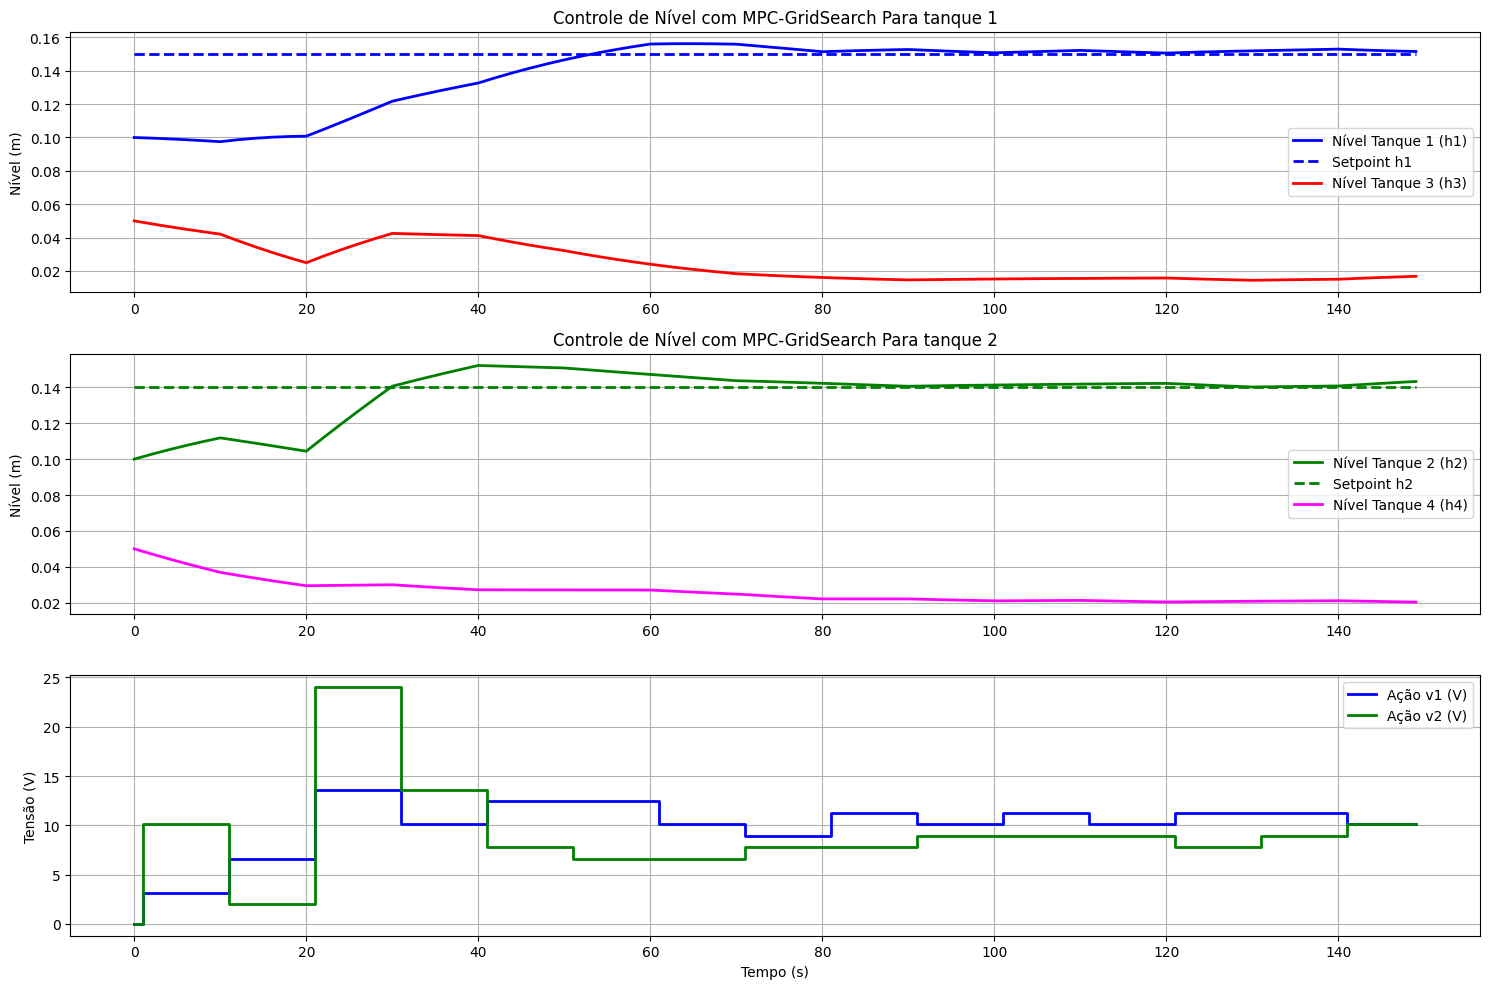

In [ ]:
import time
# ===================================================================
# SIMULA√á√ÉO DO CONTROLE MPC-GRID_SEARCH PARA O SISTEMA DE 4 TANQUES
# ===================================================================
print("\n--- Iniciando Simula√ß√£o do Controle MPC com Grid Search ---")

# --- Par√¢metros do MPC e da Busca ---
PERIODO_HOLD = 10      # Otimizar a cada 10 segundos
Np = 10               # Horizonte de predi√ß√£o
we = np.array([6e3, 6e3]) # Pesos para os erros de h1 e h2
wu = np.array([1e-3, 1e-3])   # Pesos para o custo das a√ß√µes v1 e v2

# Par√¢metros do Grid Search
GRID_PASSOS = 20 #Testar√° 20x20 = 400 combina√ß√µes.
DIMENSOES_BUSCA = 2
bounds = (np.ones(DIMENSOES_BUSCA)*2, np.full(DIMENSOES_BUSCA, VOLTAGEM_MAX))


# --- Condi√ß√µes da Simula√ß√£o (id√™nticas √† anterior) ---
N_SIM = 150 # Simular por 150 segundos, ver delta t
h_setpoints = np.array([0.15, 0.14]) # SP para h1 = 15cm, SP para h2 = 14cm
h_atuais = np.array([0.10, 0.10, 0.05, 0.05])

# Hist√≥rico para plotagem
hist_tempo_RNN = np.arange(N_SIM) * DELTA_T
hist_niveis_RNN = np.zeros((N_SIM, 4))
hist_acoes_RNN = np.zeros((N_SIM, 2))
hist_setpoints_RNN = np.tile(h_setpoints, (N_SIM, 1))

hist_niveis_RNN[0, :] = h_atuais
acoes_a_aplicar = v0_P_minus


# --- INICIALIZA√á√ÉO DO HIST√ìRICO PARA A RNN ---
# Precisamos de um hist√≥rico inicial para a primeira previs√£o
historico_completo = []
# Preenche com o estado inicial para ter o tamanho da sequ√™ncia
estado_inicial_features = np.concatenate([h_atuais, acoes_a_aplicar])
for _ in range(SEQUENCE_LENGTH):
    historico_completo.append(estado_inicial_features)


start_time = time.time()
for t in range(1, N_SIM):
    # --- L√ìGICA DO HOLD: Otimiza apenas em intervalos definidos ---
    if (t - 1) % PERIODO_HOLD == 0:
        print(f"\nPasso de controle {t}/{N_SIM-1}. Otimizando com Grid Search...")
        print(f"N√≠veis Atuais (h1,h2): [{h_atuais[0]:.3f}, {h_atuais[1]:.3f}] m")

        # Pega o hist√≥rico mais recente e normaliza
        historico_recente = np.array(historico_completo[-SEQUENCE_LENGTH:])
        historico_scaled = scaler_X.transform(historico_recente)

        cost, pos = otimizador_grid_search_rnn(
            grid_passos=GRID_PASSOS,
            bounds=bounds,
            historico_sequencial=historico_scaled, # Passa a sequ√™ncia normalizada
            h_setpoints=h_setpoints,
            Np=Np, we=we, wu=wu,
            model=model_RNN, # Usa o modelo RNN
            scaler_X=scaler_X, scaler_y=scaler_y
        )

        # A melhor posi√ß√£o 'pos' √© o vetor [v1, v2] a ser aplicado
        acoes_a_aplicar = pos
        print(f"Nova a√ß√£o calculada: [v1={acoes_a_aplicar[0]:.3f}, v2={acoes_a_aplicar[1]:.3f}] V (Custo: {cost:.2g})")


    # A simula√ß√£o do tanque continua a cada segundo, usando a √∫ltima a√ß√£o calculada
    #poderia usar a pr√≥pria info da rede neural, mas dessa forma estamos fingindo que √© o sinal emitido pela instrumenta√ß√£o
    h_atuais = simular_passo_quadruplo(h_atuais, acoes_a_aplicar)

    # Guarda os resultados
    hist_niveis_RNN[t, :] = h_atuais
    hist_acoes_RNN[t, :] = acoes_a_aplicar

    # ATUALIZA O HIST√ìRICO com o novo estado real e a a√ß√£o aplicada
    novo_vetor_features = np.concatenate([h_atuais, acoes_a_aplicar])
    historico_completo.append(novo_vetor_features)

end_time = time.time()
print(f"\nSimula√ß√£o com Grid Search conclu√≠da em {end_time - start_time:.2f} segundos.")


# 1. Calcular os sinais de erro para os tanques controlados (h1 e h2)
erro_h1_RNN = hist_setpoints_RNN[:, 0] - hist_niveis_RNN[:, 0]
erro_h2_RNN = hist_setpoints_RNN[:, 1] - hist_niveis_RNN[:, 1]

# 2. Calcular cada m√©trica para cada tanque
# M√©trica = Soma(termo) * passo_de_tempo
iae_h1_RNN = np.sum(np.abs(erro_h1_RNN)) * DELTA_T
ise_h1_RNN = np.sum(erro_h1_RNN**2) * DELTA_T
itae_h1_RNN = np.sum(hist_tempo * np.abs(erro_h1_RNN)) * DELTA_T
itse_h1_RNN = np.sum(hist_tempo * (erro_h1_RNN**2)) * DELTA_T

iae_h2_RNN = np.sum(np.abs(erro_h2_RNN)) * DELTA_T
ise_h2_RNN = np.sum(erro_h2_RNN**2) * DELTA_T
itae_h2_RNN = np.sum(hist_tempo * np.abs(erro_h2_RNN)) * DELTA_T
itse_h2_RNN = np.sum(hist_tempo * (erro_h2_RNN**2)) * DELTA_T

# 3. Exibir os resultados de forma organizada
print("\n--- M√©tricas de Performance do Controlador RNN ---")
print("----------------------------------------------")
print(f"M√©tricas para o Tanque 1 (h1):")
print(f"  IAE  (Integral Absolute Error)      = {iae_h1_RNN:.4f}")
print(f"  ISE  (Integral Squared Error)       = {ise_h1_RNN:.4f}")
print(f"  ITAE (Integral Time Abs Error)   = {itae_h1_RNN:.4f}")
print(f"  ITSE (Integral Time Squared Error) = {itse_h1_RNN:.4f}")
print("----------------------------------------------")
print(f"M√©tricas para o Tanque 2 (h2):")
print(f"  IAE  (Integral Absolute Error)      = {iae_h2_RNN:.4f}")
print(f"  ISE  (Integral Squared Error)       = {ise_h2_RNN:.4f}")
print(f"  ITAE (Integral Time Abs Error)   = {itae_h2_RNN:.4f}")
print(f"  ITSE (Integral Time Squared Error) = {itse_h2_RNN:.4f}")
print("----------------------------------------------")

# Visualiza√ß√£o
plt.figure(figsize=(15, 10))

# Gr√°fico dos n√≠veis dos tanques inferiores
plt.subplot(3, 1, 1)
plt.plot(hist_tempo_RNN, hist_niveis_RNN[:, 0], label='N√≠vel Tanque 1 (h1)', color='blue', linewidth=2)
plt.plot(hist_tempo_RNN, hist_setpoints_RNN[:, 0], label='Setpoint h1', color='blue', linestyle='--', linewidth=2)
plt.plot(hist_tempo_RNN, hist_niveis_RNN[:, 2], label='N√≠vel Tanque 3 (h3)', color='red', linewidth=2)
plt.title('Controle de N√≠vel com MPC-GridSearch Para tanque 1')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

# Gr√°fico 2 (no meio): N√≠veis dos tanques superiores (n√£o controlados)
plt.subplot(3, 1, 2)
plt.plot(hist_tempo_RNN, hist_niveis_RNN[:, 1], label='N√≠vel Tanque 2 (h2)', color='green', linewidth=2)
plt.plot(hist_tempo_RNN, hist_setpoints_RNN[:, 1], label='Setpoint h2', color='green', linestyle='--', linewidth=2)
plt.plot(hist_tempo_RNN, hist_niveis_RNN[:, 3], label='N√≠vel Tanque 4 (h4)', color='magenta', linewidth=2)
plt.title('Controle de N√≠vel com MPC-GridSearch Para tanque 2')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

# Gr√°fico das a√ß√µes de controle
plt.subplot(3, 1, 3)
plt.plot(hist_tempo_RNN, hist_acoes_RNN[:, 0], label='A√ß√£o v1 (V)', color='blue', drawstyle='steps-post', linewidth=2)
plt.plot(hist_tempo_RNN, hist_acoes_RNN[:, 1], label='A√ß√£o v2 (V)', color='green', drawstyle='steps-post', linewidth=2)
plt.ylabel('Tens√£o (V)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#LSTM

In [ ]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Hiperpar√¢metro que define o tamanho da "mem√≥ria" da RNN
SEQUENCE_LENGTH = 10

# --- Prepara√ß√£o dos dados para o modelo ---
def create_sequences(X_data, y_data, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - sequence_length):
        X_seq.append(X_data[i:(i + sequence_length)])
        y_seq.append(y_data[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

# --- Prepara√ß√£o dos dados para o modelo RNN ---
X_cols = ['h1_atual', 'h2_atual', 'h3_atual', 'h4_atual', 'v1', 'v2']
y_cols = ['h1_proximo', 'h2_proximo', 'h3_proximo', 'h4_proximo']
X_flat = df_treinamento[X_cols].values
y_flat = df_treinamento[y_cols].values
scaler_X = MinMaxScaler(); scaler_y = MinMaxScaler()
X_flat_scaled = scaler_X.fit_transform(X_flat)
y_flat_scaled = scaler_y.fit_transform(y_flat)

print(f"\nCriando sequ√™ncias com tamanho {SEQUENCE_LENGTH}...")
X_seq, y_seq = create_sequences(X_flat_scaled, y_flat_scaled, SEQUENCE_LENGTH)
print("Shape das sequ√™ncias de entrada (X):", X_seq.shape)
print("Shape das sa√≠das (y):", y_seq.shape)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# O modelo LSTM seria mais √∫til se tiv√©ssemos sequ√™ncias,
# mas para um preditor de passo √∫nico (one-step-ahead), uma Rede Neural Densa (MLP) √© suficiente e mais r√°pida.

model_LSTM = Sequential([
    # usar a ativa√ß√£o padr√£o da LSTM (tanh), que geralmente √© mais eficaz.
    LSTM(64, input_shape=(SEQUENCE_LENGTH, X_seq.shape[2])),
    Dense(32, activation='relu'),
    Dense(4)
])

model_LSTM.compile(optimizer='adam', loss='mean_squared_error')
model_LSTM.summary()

# Treinamento do modelo
print("\nIniciando treinamento do modelo...")
start_time = time.time()
history = model_LSTM.fit(
    X_train, y_train,
    epochs=50,
    batch_size=1024,
    verbose=1,
    validation_data=(X_test, y_test)
)
end_time = time.time()
print(f"\nTreinamento conclu√≠do em {end_time - start_time:.2f} segundos.")


Criando sequ√™ncias com tamanho 10...
Shape das sequ√™ncias de entrada (X): (299990, 10, 6)
Shape das sa√≠das (y): (299990, 4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 64)             ‚îÇ        18,176 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 4)              ‚îÇ           132 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 20,388 (79.64 KB)

 Trainable params: 20,388 (79.64 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando treinamento do modelo...
Epoch 1/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 81ms/step - loss: 0.0233 - val_loss: 1.2380e-04
Epoch 2/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 69ms/step - loss: 9.1949e-05 - val_loss: 3.8017e-05
Epoch 3/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 59ms/step - loss: 3.3628e-05 - val_loss: 2.4570e-05
Epoch 4/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 67ms/step - loss: 2.3033e-05 - val_loss: 1.8542e-05
Epoch 5/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 60ms/step - loss: 1.7491e-05 - val_loss: 1.4577e-05
Epoch 6/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 62ms/step - loss: 1.3649e-05 - val_loss: 1.1408e-05
Epoch 7/50
235/235 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 65ms/step - loss: 1.0709e-05 - val_loss: 8.8093e-06
Epoch 8/50
235/2

In [ ]:
@tf.function
def predict_step_compiled_LSTM(model, input_sequence_scaled):
    return model(input_sequence_scaled, training=False)

def funcao_custo_mpc_LSTM(acoes_futuras, historico_sequencial, h_setpoints, Np, we, wu, model, scaler_X, scaler_y):
    """
    Fun√ß√£o de custo para o MPC com modelo RNN.
    Usa uma janela deslizante para prever Np passos no futuro.
    """
    custo_total = tf.constant(0.0, dtype=tf.float32)

    # A sequ√™ncia inicial de inputs normalizados
    sequencia_atual_scaled = tf.constant(historico_sequencial, dtype=tf.float32)

    v1, v2 = acoes_futuras[0], acoes_futuras[1]

    # Converte os scalers para tensores
    scale_X = tf.constant(scaler_X.scale_, dtype=tf.float32)
    min_X = tf.constant(scaler_X.min_, dtype=tf.float32)
    scale_y = tf.constant(scaler_y.scale_, dtype=tf.float32)
    min_y = tf.constant(scaler_y.min_, dtype=tf.float32)

    we1, we2 = we[0], we[1]
    wu1, wu2 = wu[0], wu[1]
    h1_sp, h2_sp = h_setpoints[0], h_setpoints[1]

    for _ in range(Np):
        # A entrada para o modelo √© a sequ√™ncia completa
        # O formato j√° √© (1, sequence_length, features), ent√£o adicionamos um eixo
        entrada_modelo = tf.expand_dims(sequencia_atual_scaled, axis=0)

        # 1. FAZ A PREDI√á√ÉO
        predicao_scaled = predict_step_compiled_LSTM(model, entrada_modelo)

        # 2. DESNORMALIZA A SA√çDA
        h_proximos_preditos = (predicao_scaled / scale_y) + min_y
        h_preditos = tf.squeeze(h_proximos_preditos)

        # 3. CALCULA O CUSTO PARA ESTE PASSO
        erro_h1 = h_preditos[0] - h1_sp
        erro_h2 = h_preditos[1] - h2_sp
        custo_erro = we1 * erro_h1**2 + we2 * erro_h2**2
        custo_acao = wu1 * v1**2 + wu2 * v2**2
        custo_total += custo_erro + custo_acao*custo_erro

        # 4. ATUALIZA A SEQU√äNCIA PARA A PR√ìXIMA PREDI√á√ÉO (JANELA DESLIZANTE)
        # Cria o novo vetor de features com os n√≠veis preditos e as a√ß√µes constantes
        novo_vetor_features = tf.stack([h_preditos[0], h_preditos[1], h_preditos[2], h_preditos[3], v1, v2])
        novo_vetor_scaled = (novo_vetor_features - min_X) * scale_X

        # Adiciona o novo vetor e remove o mais antigo
        sequencia_atual_scaled = tf.concat([sequencia_atual_scaled[1:], [novo_vetor_scaled]], axis=0)

    return custo_total.numpy()

In [ ]:
def otimizador_grid_search_LSTM(grid_passos, bounds, historico_sequencial, h_setpoints, Np, we, wu, model, scaler_X, scaler_y):
    v_min = bounds[0][0]
    v_max = bounds[1][0]
    v1_range = np.linspace(v_min, v_max, grid_passos)
    v2_range = np.linspace(v_min, v_max, grid_passos)
    custo_minimo = np.inf
    melhor_acao = np.array([0.0, 0.0])

    for v1_teste in v1_range:
        for v2_teste in v2_range:
            acao_atual = np.array([v1_teste, v2_teste])
            custo = funcao_custo_mpc_LSTM(
                acao_atual, historico_sequencial, h_setpoints, Np, we, wu, model, scaler_X, scaler_y
            )
            if custo < custo_minimo:
                custo_minimo = custo
                melhor_acao = acao_atual
    return custo_minimo, melhor_acao


--- Iniciando Simula√ß√£o do Controle MPC com Grid Search ---

Passo de controle 1/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.100, 0.100] m
Nova a√ß√£o calculada: [v1=15.895, v2=21.684] V (Custo: 59)

Passo de controle 11/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.132, 0.136] m
Nova a√ß√£o calculada: [v1=8.947, v2=2.000] V (Custo: 2.5)

Passo de controle 21/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.140, 0.128] m
Nova a√ß√£o calculada: [v1=13.579, v2=14.737] V (Custo: 5.6)

Passo de controle 31/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.156, 0.146] m
Nova a√ß√£o calculada: [v1=7.789, v2=6.632] V (Custo: 1.9)

Passo de controle 41/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.154, 0.144] m
Nova a√ß√£o calculada: [v1=10.105, v2=8.947] V (Custo: 0.018)

Passo de controle 51/149. Otimizando com Grid Search...
N√≠veis Atuais (h1,h2): [0.156, 0.147] m
Nova a√ß√£o calculada: [v1=8.947, v2=6.632] V (Cu

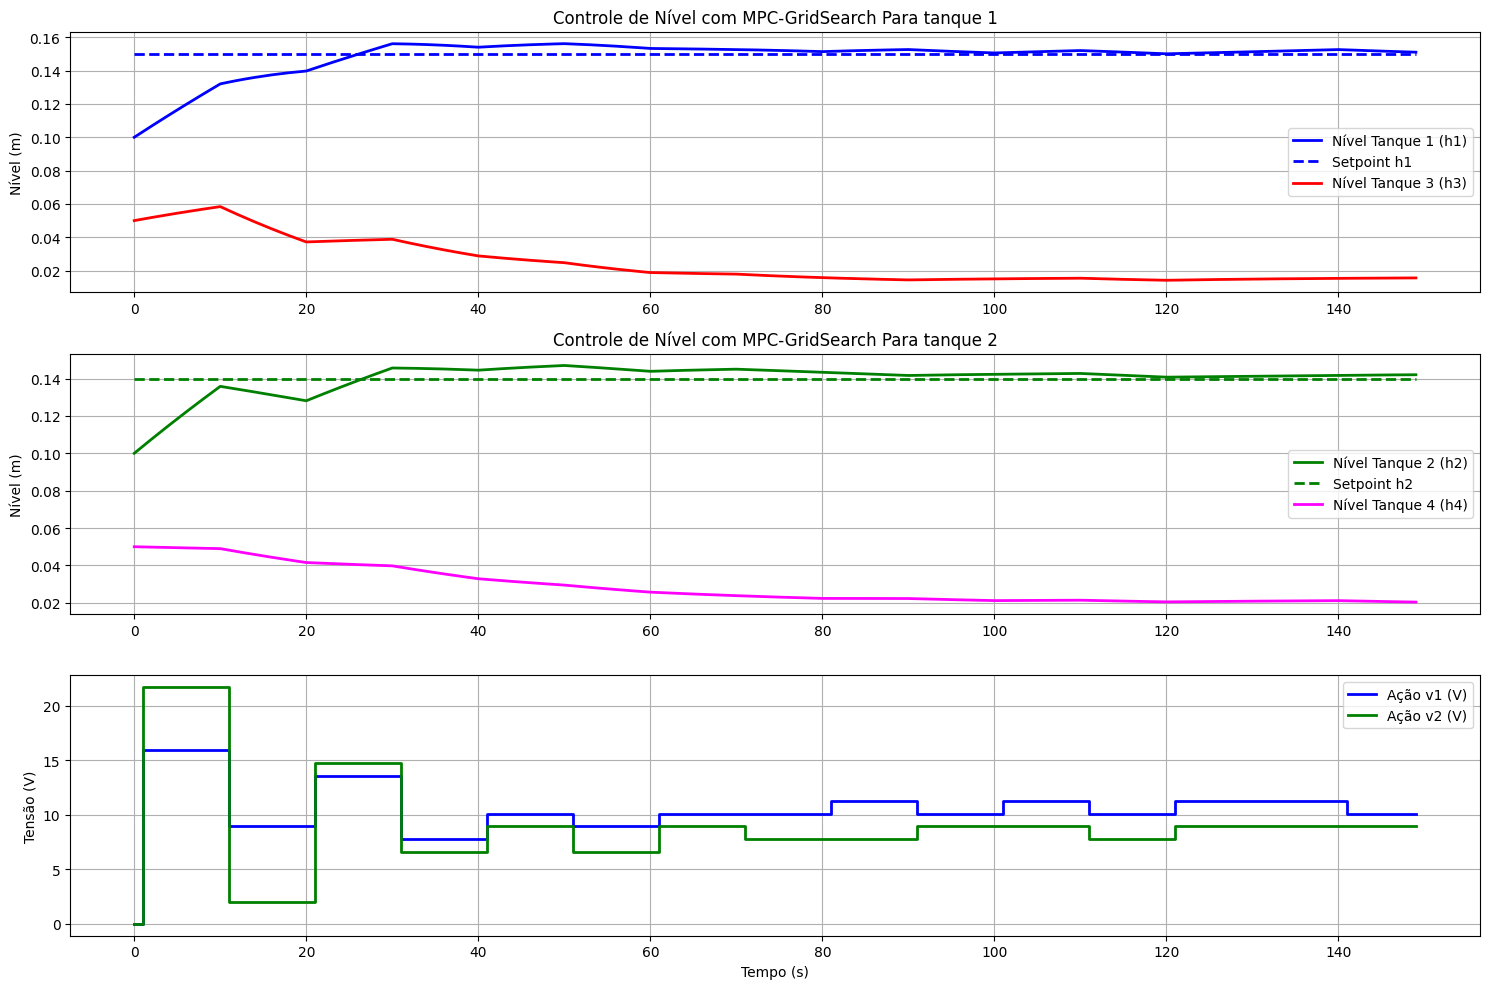

In [ ]:
# ===================================================================
# SIMULA√á√ÉO DO CONTROLE MPC-GRID_SEARCH PARA O SISTEMA DE 4 TANQUES
# ===================================================================
print("\n--- Iniciando Simula√ß√£o do Controle MPC com Grid Search ---")

# --- Par√¢metros do MPC e da Busca ---
PERIODO_HOLD = 10      # Otimizar a cada 10 segundos
Np = 10               # Horizonte de predi√ß√£o
we = np.array([6e3, 6e3]) # Pesos para os erros de h1 e h2
wu = np.array([1e-3, 1e-3])   # Pesos para o custo das a√ß√µes v1 e v2

# Par√¢metros do Grid Search
GRID_PASSOS = 20 #Testar√° 20x20 = 400 combina√ß√µes.
DIMENSOES_BUSCA = 2
bounds = (np.ones(DIMENSOES_BUSCA)*2, np.full(DIMENSOES_BUSCA, VOLTAGEM_MAX))


# --- Condi√ß√µes da Simula√ß√£o (id√™nticas √† anterior) ---
N_SIM = 150 # Simular por 150 segundos, ver delta t
h_setpoints = np.array([0.15, 0.14]) # SP para h1 = 15cm, SP para h2 = 14cm
h_atuais = np.array([0.10, 0.10, 0.05, 0.05])

# Hist√≥rico para plotagem
hist_tempo_LSTM = np.arange(N_SIM) * DELTA_T
hist_niveis_LSTM = np.zeros((N_SIM, 4))
hist_acoes_LSTM = np.zeros((N_SIM, 2))
hist_setpoints_LSTM = np.tile(h_setpoints, (N_SIM, 1))

hist_niveis_LSTM[0, :] = h_atuais
acoes_a_aplicar = v0_P_minus


# --- INICIALIZA√á√ÉO DO HIST√ìRICO PARA A RNN ---
# Precisamos de um hist√≥rico inicial para a primeira previs√£o
historico_completo = []
# Preenche com o estado inicial para ter o tamanho da sequ√™ncia
estado_inicial_features = np.concatenate([h_atuais, acoes_a_aplicar])
for _ in range(SEQUENCE_LENGTH):
    historico_completo.append(estado_inicial_features)


start_time = time.time()
for t in range(1, N_SIM):
    # --- L√ìGICA DO HOLD: Otimiza apenas em intervalos definidos ---
    if (t - 1) % PERIODO_HOLD == 0:
        print(f"\nPasso de controle {t}/{N_SIM-1}. Otimizando com Grid Search...")
        print(f"N√≠veis Atuais (h1,h2): [{h_atuais[0]:.3f}, {h_atuais[1]:.3f}] m")

        # Pega o hist√≥rico mais recente e normaliza
        historico_recente = np.array(historico_completo[-SEQUENCE_LENGTH:])
        historico_scaled = scaler_X.transform(historico_recente)

        cost, pos = otimizador_grid_search_LSTM(
            grid_passos=GRID_PASSOS,
            bounds=bounds,
            historico_sequencial=historico_scaled, # Passa a sequ√™ncia normalizada
            h_setpoints=h_setpoints,
            Np=Np, we=we, wu=wu,
            model=model_LSTM,
            scaler_X=scaler_X, scaler_y=scaler_y
        )

        # A melhor posi√ß√£o 'pos' √© o vetor [v1, v2] a ser aplicado
        acoes_a_aplicar = pos
        print(f"Nova a√ß√£o calculada: [v1={acoes_a_aplicar[0]:.3f}, v2={acoes_a_aplicar[1]:.3f}] V (Custo: {cost:.2g})")


    # A simula√ß√£o do tanque continua a cada segundo, usando a √∫ltima a√ß√£o calculada
    #poderia usar a pr√≥pria info da rede neural, mas dessa forma estamos fingindo que √© o sinal emitido pela instrumenta√ß√£o
    h_atuais = simular_passo_quadruplo(h_atuais, acoes_a_aplicar)

    # Guarda os resultados
    hist_niveis_LSTM[t, :] = h_atuais
    hist_acoes_LSTM[t, :] = acoes_a_aplicar

    # ATUALIZA O HIST√ìRICO com o novo estado real e a a√ß√£o aplicada
    novo_vetor_features = np.concatenate([h_atuais, acoes_a_aplicar])
    historico_completo.append(novo_vetor_features)

end_time = time.time()
print(f"\nSimula√ß√£o com Grid Search conclu√≠da em {end_time - start_time:.2f} segundos.")

# 1. Calcular os sinais de erro para os tanques controlados (h1 e h2)
erro_h1_LSTM = hist_setpoints_LSTM[:, 0] - hist_niveis_LSTM[:, 0]
erro_h2_LSTM = hist_setpoints_LSTM[:, 1] - hist_niveis_LSTM[:, 1]

# 2. Calcular cada m√©trica para cada tanque
# M√©trica = Soma(termo) * passo_de_tempo
iae_h1_LSTM = np.sum(np.abs(erro_h1_LSTM)) * DELTA_T
ise_h1_LSTM = np.sum(erro_h1_LSTM**2) * DELTA_T
itae_h1_LSTM = np.sum(hist_tempo_LSTM * np.abs(erro_h1_LSTM)) * DELTA_T
itse_h1_LSTM = np.sum(hist_tempo_LSTM * (erro_h1_LSTM**2)) * DELTA_T

iae_h2_LSTM = np.sum(np.abs(erro_h2_LSTM)) * DELTA_T
ise_h2_LSTM = np.sum(erro_h2_LSTM**2) * DELTA_T
itae_h2_LSTM = np.sum(hist_tempo_LSTM * np.abs(erro_h2_LSTM)) * DELTA_T
itse_h2_LSTM = np.sum(hist_tempo_LSTM * (erro_h2_LSTM**2)) * DELTA_T

# 3. Exibir os resultados de forma organizada
print("\n--- M√©tricas de Performance do Controlador ---")
print("----------------------------------------------")
print(f"M√©tricas para o Tanque 1 LSTM (h1):")
print(f"  IAE  (Integral Absolute Error)      = {iae_h1_LSTM:.4f}")
print(f"  ISE  (Integral Squared Error)       = {ise_h1_LSTM:.4f}")
print(f"  ITAE (Integral Time Abs Error)   = {itae_h1_LSTM:.4f}")
print(f"  ITSE (Integral Time Squared Error) = {itse_h1_LSTM:.4f}")
print("----------------------------------------------")
print(f"M√©tricas para o Tanque 2 (h2):")
print(f"  IAE  (Integral Absolute Error)      = {iae_h2_LSTM:.4f}")
print(f"  ISE  (Integral Squared Error)       = {ise_h2_LSTM:.4f}")
print(f"  ITAE (Integral Time Abs Error)   = {itae_h2_LSTM:.4f}")
print(f"  ITSE (Integral Time Squared Error) = {itse_h2_LSTM:.4f}")
print("----------------------------------------------")

# Visualiza√ß√£o
plt.figure(figsize=(15, 10))

# Gr√°fico dos n√≠veis dos tanques da esquerda
plt.subplot(3, 1, 1)
plt.plot(hist_tempo_LSTM, hist_niveis_LSTM[:, 0], label='N√≠vel Tanque 1 (h1)', color='blue', linewidth=2)
plt.plot(hist_tempo_LSTM, hist_setpoints_LSTM[:, 0], label='Setpoint h1', color='blue', linestyle='--', linewidth=2)
plt.plot(hist_tempo_LSTM, hist_niveis_LSTM[:, 2], label='N√≠vel Tanque 3 (h3)', color='red', linewidth=2)
plt.title('Controle de N√≠vel com MPC-GridSearch Para tanque 1')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

# Gr√°fico 2 (no meio): N√≠veis dos tanques da direita
plt.subplot(3, 1, 2)
plt.plot(hist_tempo_LSTM, hist_niveis_LSTM[:, 1], label='N√≠vel Tanque 2 (h2)', color='green', linewidth=2)
plt.plot(hist_tempo_LSTM, hist_setpoints_LSTM[:, 1], label='Setpoint h2', color='green', linestyle='--', linewidth=2)
plt.plot(hist_tempo_LSTM, hist_niveis_LSTM[:, 3], label='N√≠vel Tanque 4 (h4)', color='magenta', linewidth=2)
plt.title('Controle de N√≠vel com MPC-GridSearch Para tanque 2')
plt.ylabel('N√≠vel (m)')
plt.legend()
plt.grid(True)

# Gr√°fico das a√ß√µes de controle
plt.subplot(3, 1, 3)
plt.plot(hist_tempo_LSTM, hist_acoes_LSTM[:, 0], label='A√ß√£o v1 (V)', color='blue', drawstyle='steps-post', linewidth=2)
plt.plot(hist_tempo_LSTM, hist_acoes_LSTM[:, 1], label='A√ß√£o v2 (V)', color='green', drawstyle='steps-post', linewidth=2)
plt.ylabel('Tens√£o (V)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()